In [1]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Analyzing the Impact of Demographic and Environmental Factors on Traffic Accidents in the U.S.

## Introduction
Traffic accidents are a major public safety issue in the United States, leading to significant economic costs, injuries, and fatalities. While environmental factors like weather are well-known contributors, the role of demographic and socioeconomic factors is less understood.

This project explores the relationship between traffic accidents and demographic characteristics across U.S. counties. By merging traffic accident data with U.S. Census demographic information, I aim to identify how factors such as income, population density, and employment influence accident rates and severity. This analysis seeks to uncover patterns that could inform more effective road safety policies and interventions.

## Research Questions:
1. How do demographic factors influence the frequency and severity of traffic accidents?
2. What is the impact of weather conditions on accident rates across different counties?
3. How do different times of day (civil twilight, sunrise/sunset) affect accident rates across various counties?
4. How does the presence of traffic control measures (e.g., traffic signals, roundabouts) vary across counties with different demographic profiles?
5. Hypotheses Related to Time Series Data:
- Seasonal Variations in Accident Rates
- Daily and Weekly Patterns
- Effect of Time of Day on Accident Severity
- Impact of Daylight on Accident Rates

To begin the project, I will start by exploring the U.S. Census demographic dataset to understand its structure and key variables, such as population, income, and employment across counties. This initial exploration will help me familiarize myself with the data and prepare for its integration with the traffic accident dataset in the next phase.

## Understanding the U.S. Census demographic Dataset
This dataset provides comprehensive demographic and economic information for U.S. counties for the **year 2017**, offering a rich snapshot of the socio-economic landscape across various regions.

First of all, let's read the dataset.

In [2]:
census = pd.read_csv("acs2017_county_data.csv")  

I will display the first few rows to understand the structure

In [3]:
census.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


Now, I am going to take a detailed look at the dataset and its columns, gaining a solid understanding of the characteristics, distributions, and relationships of each column in the dataset. I will then be able to proceed with more in-depth analysis and visualizations based on these initial findings.

Let's see the names of the columns

In [4]:
census.columns

Index(['CountyId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

To ensure high-quality analysis, it's essential to understand the meaning of every column in the dataset. Each column represents a specific aspect of the data, and without a clear understanding of what each one signifies, the analysis could lead to inaccurate conclusions. Let's make some groups.<br>
1. `CountyId`, `State`, `County` - unique identifiers and geographical information
2. `TotalPop`, `Men`, `Women` - population metrics
3. `Hispanic`, `White`, `Black`, `Native`, `Asian`, `Pacific` - ethnic demographics
4. `VotingAgeCitizen` - number of citizens eligible to vote
5. `Income`, `IncomeErr`, `IncomePerCap`, `IncomePerCapErr` - economic data
6. `Poverty`, `ChildPoverty` - poverty metrics
7. `Professional`, `Service`, `Office`, `Construction`, `Production` - employment sectors
8. `Drive`, `Carpool`, `Transit`, `Walk`, `OtherTransp`, `WorkAtHome` - transportation methods
9. `MeanCommute` - average commute time
10. `Employed`, `PrivateWork`, `PublicWork`, `SelfEmployed`, `FamilyWork`, `Unemployment` - employment metrics

I am not very impressed by the names! Why? Because in Python, it's common practice to use snake case (e.g., `county_id` instead of `CountyId`) for variable and column names. To maintain consistency and improve code readability, it's a good idea to rename the columns in our dataset to follow this convention.

In [5]:
def to_snake_case(column_name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()

# Convert each word in the list to snake case
census.columns = [to_snake_case(column) for column in census.columns]

In [6]:
census.columns

Index(['county_id', 'state', 'county', 'total_pop', 'men', 'women', 'hispanic',
       'white', 'black', 'native', 'asian', 'pacific', 'voting_age_citizen',
       'income', 'income_err', 'income_per_cap', 'income_per_cap_err',
       'poverty', 'child_poverty', 'professional', 'service', 'office',
       'construction', 'production', 'drive', 'carpool', 'transit', 'walk',
       'other_transp', 'work_at_home', 'mean_commute', 'employed',
       'private_work', 'public_work', 'self_employed', 'family_work',
       'unemployment'],
      dtype='object')

Yeah, we're PYTHONS now and I can continue with the dataset review using the `info()` method! This method is useful for getting an overview of the dataset, identifying missing data, and understanding the structure of the DataFrame.

In [7]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   county_id           3220 non-null   int64  
 1   state               3220 non-null   object 
 2   county              3220 non-null   object 
 3   total_pop           3220 non-null   int64  
 4   men                 3220 non-null   int64  
 5   women               3220 non-null   int64  
 6   hispanic            3220 non-null   float64
 7   white               3220 non-null   float64
 8   black               3220 non-null   float64
 9   native              3220 non-null   float64
 10  asian               3220 non-null   float64
 11  pacific             3220 non-null   float64
 12  voting_age_citizen  3220 non-null   int64  
 13  income              3220 non-null   int64  
 14  income_err          3220 non-null   int64  
 15  income_per_cap      3220 non-null   int64  
 16  income

I obtained important information such as the number of records (rows), the number of columns, the column names, the data types, and the number of non-zero values in each column.

### Data Cleaning and Preparation

In [8]:
# Better checking for missing values
missing_values = census.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing Values in Columns:")
print(missing_values)

Missing Values in Columns:
child_poverty    1
dtype: int64


In [9]:
# Check the percentage of missing data in each column
missing_percentage = (missing_values / len(census)) * 100
print("Percentage of missing values:\n", missing_percentage)

Percentage of missing values:
 child_poverty    0.031056
dtype: float64


Only one missing value! `IMPUTATION`! To handle missing values in numerical columns, I can replace them with the column's mean, median, or mode.

In [10]:
# Mean imputation for 'child_poverty and  no more missing values'
census['child_poverty'].fillna(census['child_poverty'].mean(), inplace=True)

Nice, but seeing the data types I think I should do some changes. For example columns like `state` or `county` should be categorical.

In [11]:
census['state'] = census['state'].astype('category')
census['county'] = census['county'].astype('category')

It's easy to see that most of the columns in the dataset are numeric. To gain more detailed insights into these numeric columns, we can use the `describe()` method. This method provides summary statistics, such as the mean, median, standard deviation, and range, giving us a better understanding of the distribution and characteristics of the numeric data.

In [12]:
# Summary statistics for numerical columns
census.describe().T

,count,mean,std,min,25%,50%,75%,max
county_id,3220.0,31393.605280,16292.078954,1001.0,19032.500,30024.0,46105.500,72153.0
total_pop,3220.0,100768.127329,324499.589466,74.0,11213.500,25847.5,66608.250,10105722.0
men,3220.0,49587.810559,159321.182902,39.0,5645.500,12879.0,33017.250,4979641.0
women,3220.0,51180.316770,165216.389158,35.0,5553.500,12993.5,33593.750,5126081.0
hispanic,3220.0,11.296584,19.342522,0.0,2.100,4.1,10.000,100.0
white,3220.0,74.920186,23.056700,0.0,63.500,83.6,92.800,100.0
black,3220.0,8.681957,14.333571,0.0,0.600,2.0,9.500,86.9
native,3220.0,1.768416,7.422946,0.0,0.100,0.3,0.600,90.3
asian,3220.0,1.289379,2.716191,0.0,0.200,0.6,1.200,41.8
pacific,3220.0,0.083416,0.709277,0.0,0.000,0.0,0.100,33.7


### Exploratory Data Analysis (EDA)

#### Demographic Distribution

In this section, I will begin by reviewing population data to establish a foundation for the demographic analysis. I will focus on the total population and its gender breakdown. To do this, I will generate descriptive statistics for the total_pop, male, and female columns. This summary will provide insight into the central trends and variability in the dataset.

In [13]:
# Summary statistics for population columns
population_columns = ['total_pop', 'men', 'women']
census[population_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
total_pop,3220.0,100768.127329,324499.589466,74.0,11213.5,25847.5,66608.25,10105722.0
men,3220.0,49587.810559,159321.182902,39.0,5645.5,12879.0,33017.25,4979641.0
women,3220.0,51180.316770,165216.389158,35.0,5553.5,12993.5,33593.75,5126081.0


As a next step, I will calculate and print the total population, along with the totals for women and men. This will give a clear view of the overall population and its gender distribution.

In [14]:
total_population = census['total_pop'].sum()
print(f"The total population in USA is: {total_population}")

The total population in USA is: 324473370


In [15]:
total_men_population = census['men'].sum()
print(f"The total men population in USA is: {total_men_population}")

The total men population in USA is: 159672750


In [16]:
total_women_population = census['women'].sum()
print(f"The total women population in USA is: {total_women_population}")

The total women population in USA is: 164800620


After calculating and printing the total population, as well as the populations of men and women, the next step is to visualize this data to better understand the gender distribution within the total population.

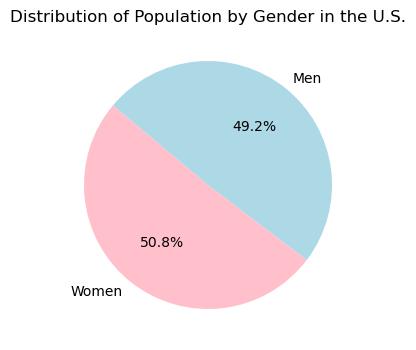

In [17]:
populations = [total_women_population, total_men_population]
labels = ['Women', 'Men']
plt.figure(figsize=(4, 10))
plt.pie(populations, labels=labels, autopct='%1.1f%%', colors=['pink', 'lightblue'], startangle=140)

plt.title('Distribution of Population by Gender in the U.S.')

plt.show()

We can clearly see that women are more.

I'm curious to know which are the regions with the most and least total population. To achieve this, I will find the rows in the dataset that contain the maximum and minimum values in the `total_pop` column. This will allow me to see which counties and states have the largest populations as well as which have the smallest.

In [18]:
# The row that contains max total population
max_population_row = census[census.total_pop == census.total_pop.max()]

print("County and state with the highest total population: ")
max_population_row[['county', 'state', 'total_pop']]

County and state with the highest total population: 


,county,state,total_pop
204,Los Angeles County,California,10105722


In [19]:
# The row that contains minimum total population
min_population_row = census[census.total_pop == census.total_pop.min()]

print("County and state with the lowest total population: ")
min_population_row[['county', 'state', 'total_pop']]

County and state with the lowest total population: 


,county,state,total_pop
2673,Loving County,Texas,74


I will use this type of analysis to understand the distribution of different ethnic groups, income levels, and poverty levels across counties.

In [20]:
ethnic_columns = ['hispanic', 'white', 'black', 'native', 'asian', 'pacific']
census[ethnic_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
hispanic,3220.0,11.296584,19.342522,0.0,2.1,4.1,10.0,100.0
white,3220.0,74.920186,23.056700,0.0,63.5,83.6,92.8,100.0
black,3220.0,8.681957,14.333571,0.0,0.6,2.0,9.5,86.9
native,3220.0,1.768416,7.422946,0.0,0.1,0.3,0.6,90.3
asian,3220.0,1.289379,2.716191,0.0,0.2,0.6,1.2,41.8
pacific,3220.0,0.083416,0.709277,0.0,0.0,0.0,0.1,33.7


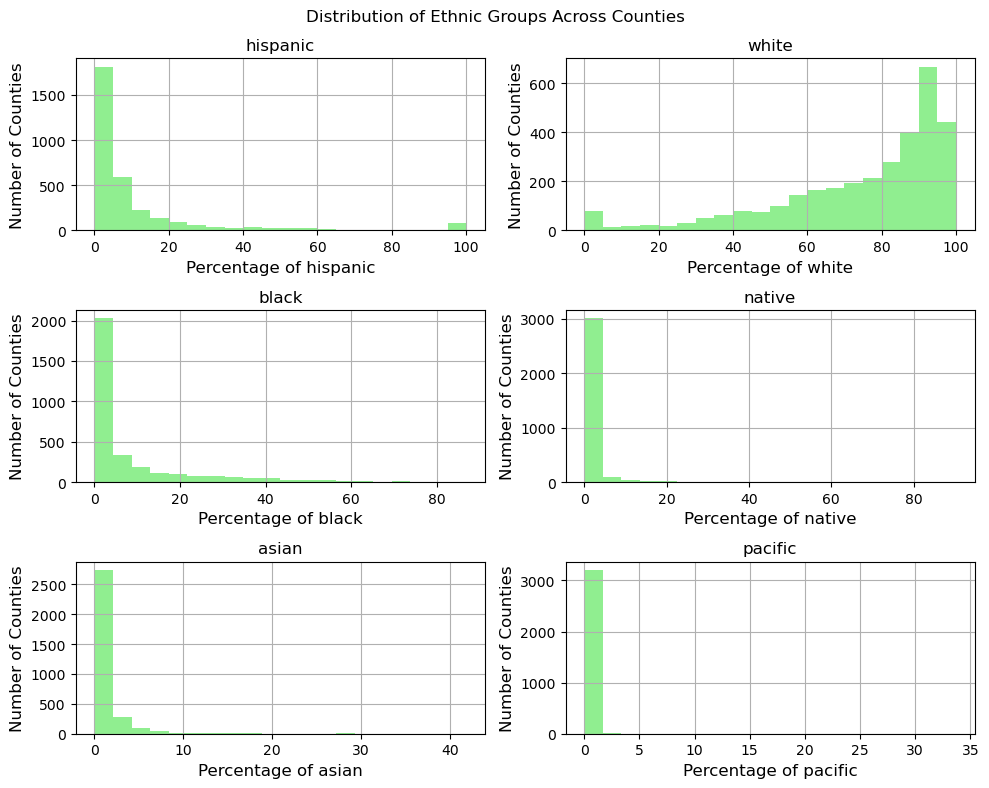

In [21]:
# Distribution of ethnic groups

census[ethnic_columns].hist(bins=20, figsize=(10, 8), color='lightgreen')
plt.suptitle('Distribution of Ethnic Groups Across Counties')

for ax, col in zip(plt.gcf().get_axes(), ethnic_columns):
    ax.set_xlabel(f'Percentage of {col}', fontsize=12)
    ax.set_ylabel('Number of Counties', fontsize=12)
    
plt.tight_layout()
plt.show()

The histograms reveal significant ethnic diversity across U.S. counties. Most counties are predominantly white, with a large concentration showing 80-100% White populations. Hispanic and black populations are more dispersed, with most counties having less than 20% of these groups, though some counties exhibit very high concentrations. Native, Asian, and Pacific Islander populations are largely absent in many counties, with significant presence only in specific regions. This suggests a pattern of ethnic concentration in certain areas, while many counties remain ethnically homogeneous.

In [22]:
# Summary descriptive statistics for economic columns
economic_columns = ['income', 'income_err', 'income_per_cap', 'income_per_cap_err', 'poverty', 'child_poverty']
census[economic_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
income,3220.0,48994.966770,13877.178398,11680.0,40622.000,47636.5,55476.0,129588.0
income_err,3220.0,3138.616770,2405.786950,262.0,1729.750,2587.0,3802.0,41001.0
income_per_cap,3220.0,25657.033230,6667.520452,5943.0,21568.000,25139.0,28997.0,69529.0
income_per_cap_err,3220.0,1514.442547,1156.708587,129.0,832.000,1225.0,1802.5,16145.0
poverty,3220.0,16.780776,8.309360,2.4,11.475,15.4,19.8,65.2
child_poverty,3220.0,23.040634,11.890087,0.0,14.900,21.5,28.6,83.6


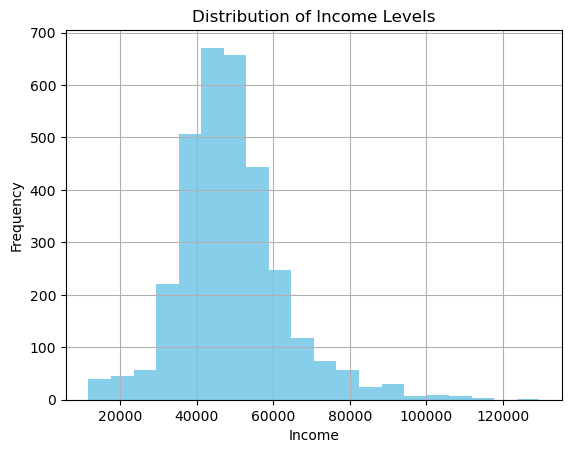

In [23]:
# Distribution of income levels

census['income'].hist(bins=20, color='skyblue')
plt.title('Distribution of Income Levels')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

The histogram reveals that the most common income range is between `$40,000` and `$60,000`, indicating that a large portion of the population falls within this bracket. The distribution is roughly bell-shaped, suggesting a normal distribution of income levels with symmetry around the central peak. There are fewer individuals with very high or very low incomes, as seen by the sharp decline in frequency on either side of the peak.

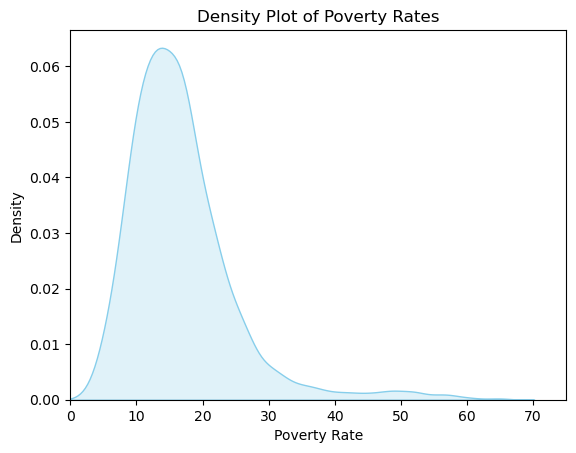

In [24]:
# Explore the distribution of poverty rates.

sns.kdeplot(census['poverty'], fill=True, color='skyblue')
plt.title('Density Plot of Poverty Rates')
plt.xlabel('Poverty Rate')
plt.xlim(0, 75)
plt.show()

The density plot shows that the most common poverty rate is around 10%, with a majority of regions falling within this range. However, the plot is right-skewed, indicating that while most areas have lower poverty rates, there are some with significantly higher rates, extending up to 70%. This visualization is important for understanding the distribution of poverty across regions and is valuable for economists, policymakers, and social scientists focused on poverty and income inequality.

#### Correlation Analysis

In [25]:
correlation_matrix = census[['income', 'poverty', 'professional', 'service', 'unemployment']].corr()
correlation_matrix

,income,poverty,professional,service,unemployment
income,1.000000,-0.764594,0.592376,-0.359235,-0.506737
poverty,-0.764594,1.000000,-0.348950,0.378409,0.730875
professional,0.592376,-0.348950,1.000000,-0.295039,-0.262633
service,-0.359235,0.378409,-0.295039,1.000000,0.344190
unemployment,-0.506737,0.730875,-0.262633,0.344190,1.000000


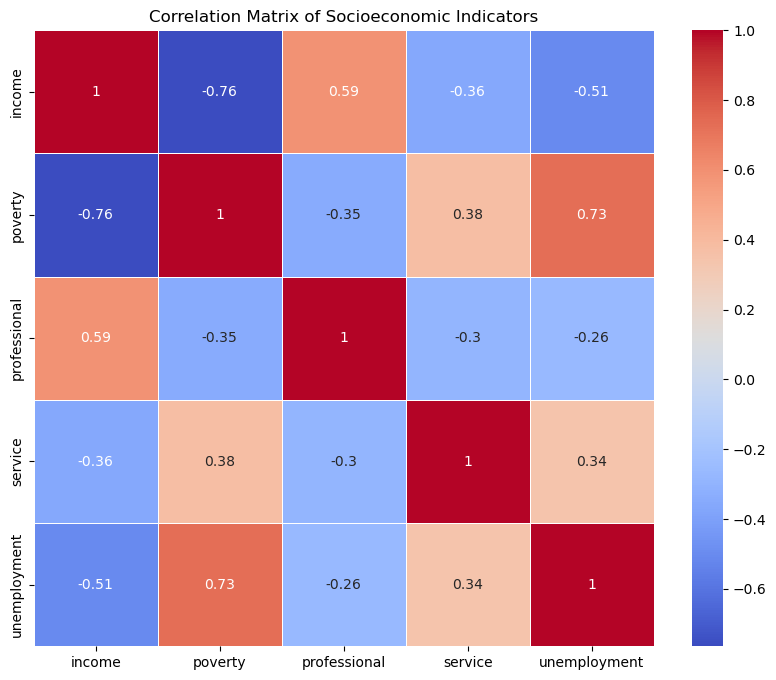

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Socioeconomic Indicators')
plt.show()

The heatmap reveals how interconnected these socioeconomic variables are. Key takeaways include:

Higher income tends to be associated with lower poverty and unemployment, and higher professional employment.
Poverty is closely linked with higher unemployment and more prevalent service occupations.
The presence of professional jobs is beneficial for reducing poverty and increasing income, while a reliance on service jobs may be linked with higher poverty and lower income.
These insights can be particularly useful for policymakers and researchers focusing on economic development, employment strategies, and poverty reduction.

### Comparative Studies

#### State vs. County Analysis

I will begin with the `state` column.
Using the `value_counts()` method is a good first step for understanding the distribution of counties across different states in our dataset.

In [27]:
# Unique states and their frequency
census['state'].value_counts()

state
Texas                   254
Georgia                 159
Virginia                133
Kentucky                120
Missouri                115
Kansas                  105
Illinois                102
North Carolina          100
Iowa                     99
Tennessee                95
Nebraska                 93
Indiana                  92
Ohio                     88
Minnesota                87
Michigan                 83
Mississippi              82
Puerto Rico              78
Oklahoma                 77
Arkansas                 75
Wisconsin                72
Florida                  67
Pennsylvania             67
Alabama                  67
South Dakota             66
Colorado                 64
Louisiana                64
New York                 62
California               58
Montana                  56
West Virginia            55
North Dakota             53
South Carolina           46
Idaho                    44
Washington               39
Oregon                   36
New Mexico    

In [28]:
# Let's see the number of unique counties
print(f"Number of unique counties: {census['county'].nunique()}")

Number of unique counties: 1955


After this, I want to aggregate data at the state level to compare states on various metrics (e.g., average income, poverty rates).

In [29]:
state_aggregates = census.groupby('state').agg({
    'income': 'mean',
    'poverty': 'mean',
    'unemployment': 'mean'
}).reset_index()

C:\Users\Цецо\AppData\Local\Temp\ipykernel_11604\3592530104.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_aggregates = census.groupby('state').agg({


In [30]:
state_aggregates.head(10)

,state,income,poverty,unemployment
0,Alabama,40271.402985,20.949254,9.023881
1,Alaska,66425.448276,13.555172,9.655172
2,Arizona,45816.666667,20.193333,9.766667
3,Arkansas,39025.080000,20.421333,7.292000
4,California,61046.758621,15.737931,8.265517
5,Colorado,54353.562500,13.234375,5.793750
6,Connecticut,74496.000000,9.200000,6.775000
7,Delaware,61294.666667,12.300000,6.433333
8,District of Columbia,77649.000000,17.400000,8.000000
9,Florida,47144.328358,17.150746,7.765672


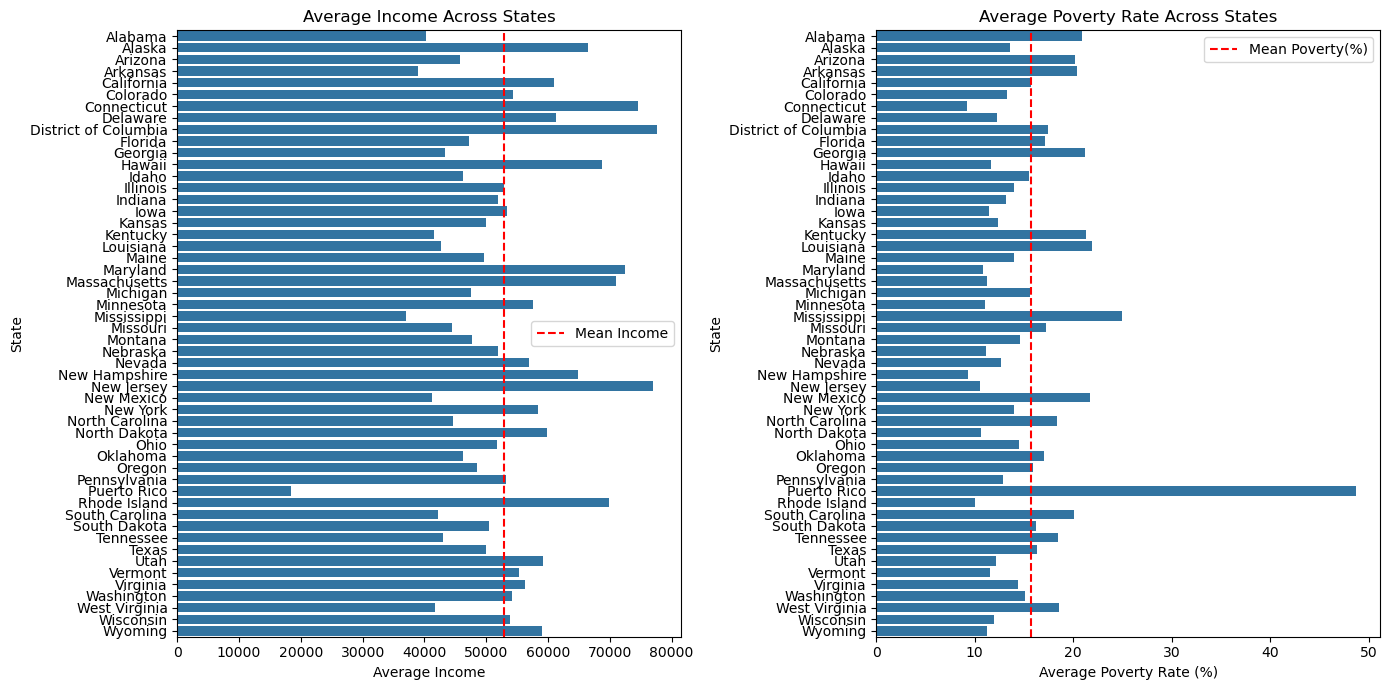

In [31]:
mean_income = state_aggregates['income'].mean()
mean_poverty = state_aggregates['poverty'].mean()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='income', y='state', data=state_aggregates.sort_values('income', ascending=False))
plt.title('Average Income Across States')
plt.xlabel('Average Income')
plt.ylabel('State')
plt.axvline(mean_income, color='red', linestyle='--', label='Mean Income')
plt.legend()


plt.subplot(1, 2, 2)
sns.barplot(x='poverty', y='state', data=state_aggregates.sort_values('poverty', ascending=False))
plt.title('Average Poverty Rate Across States')
plt.xlabel('Average Poverty Rate (%)')
plt.ylabel('State')
plt.axvline(mean_poverty, color='red', linestyle='--', label='Mean Poverty(%)')
plt.legend()

plt.tight_layout()
plt.show()

#### Education Level vs. Income Analysis
In this section, I will analyze how the share of people employed in professional occupations affects median income and poverty rates.

To begin my analysis of how educational attainment influences income and poverty levels, the first step is to examine the relationship between professional employment and these economic factors. Specifically, I will group the data by the proportion of people employed in professional occupations and calculate the average income and poverty rates for each group. This initial analysis will provide insights into how different levels of professional employment are associated with variations in income and poverty across different regions.

In [32]:
education_income_analysis = census.groupby('professional').agg({
    'income': 'mean',
    'poverty': 'mean'
}).reset_index()

In [33]:
education_income_analysis

,professional,income,poverty
0,11.4,25609.0,40.3
1,13.7,26750.0,22.8
2,14.0,48462.0,7.0
3,14.3,28490.0,29.3
4,15.2,35435.0,29.9
...,...,...,...
351,60.9,115576.0,5.2
352,61.7,77649.0,17.4
353,67.3,114795.0,2.9
354,67.7,110190.0,5.1


The analysis shows a clear pattern: as the proportion of people in professional occupations increases, both average income and poverty rates improve. **Regions with higher professional employment (around 67%) have much higher incomes (up to \%115,000) and lower poverty rates (as low as 2.9%).** Conversely, **areas with lower professional employment (around 11%) have lower incomes (about \$25,000) and higher poverty rates (up to 40.3%).** This indicates that higher professional employment is linked to better economic outcomes and reduced poverty.

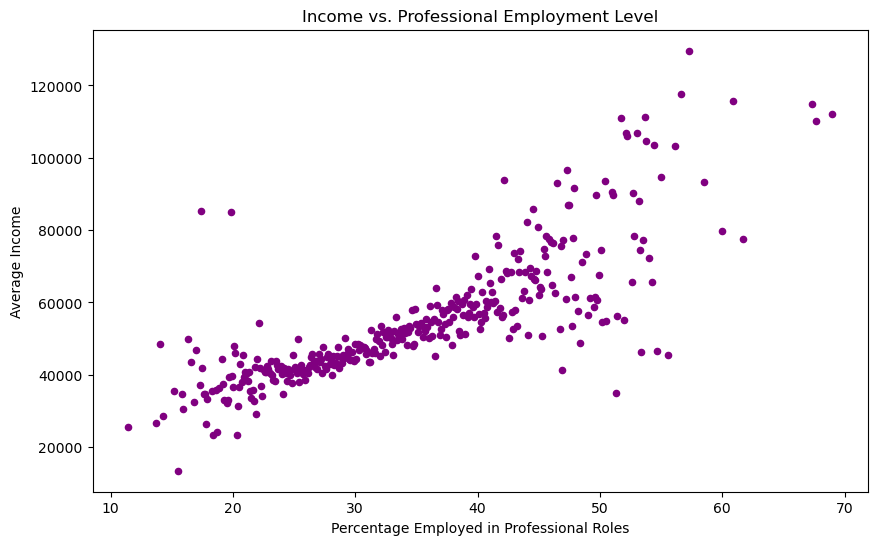

In [34]:
education_income_analysis.plot(kind='scatter', x='professional', y='income', figsize=(10, 6), color='purple')
plt.title('Income vs. Professional Employment Level')
plt.xlabel('Percentage Employed in Professional Roles')
plt.ylabel('Average Income')
plt.show()

The scatter plot illustrates the relationship between the percentage of employment in professional roles and average income. There is a noticeable positive correlation between the percentage of people employed in professional roles and average income. As the proportion of professional employment rises, so does the average income. This pattern supports the idea that regions with a larger proportion of professional roles tend to experience better economic outcomes. The increasing spread of data points at higher professional employment percentages also suggests that the impact of professional employment on income becomes more pronounced in regions with substantial professional job representation.

## Understanding the U.S. Accidents Dataset

It's time to understand the second data source which is a countrywide car accident dataset that covers 49 states of the USA.
The US-Accidents dataset can be used for numerous applications, such as real-time car accident prediction, studying car accident hotspot locations, casualty analysis, extracting cause and effect rules to predict car accidents, and studying the impact of precipitation or other environmental stimuli on accident occurrence.

Let's read it and display the first few rows.

In [35]:
accidents = pd.read_csv("US_Accidents_March23_sampled_500k.csv")

In [36]:
print("First 5 rows of the dataset:")
accidents.head()

First 5 rows of the dataset:


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [37]:
# Checking the columns
accidents.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

It will be better if they are in snake case, so I will do it again.

In [38]:
# Columns to snake case
def to_snake_case(column_name):
    return column_name.lower()

accidents.columns = [to_snake_case(column) for column in accidents.columns]

In [39]:
accidents.columns

Index(['id', 'source', 'severity', 'start_time', 'end_time', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'distance(mi)', 'description',
       'street', 'city', 'county', 'state', 'zipcode', 'country', 'timezone',
       'airport_code', 'weather_timestamp', 'temperature(f)', 'wind_chill(f)',
       'humidity(%)', 'pressure(in)', 'visibility(mi)', 'wind_direction',
       'wind_speed(mph)', 'precipitation(in)', 'weather_condition', 'amenity',
       'bump', 'crossing', 'give_way', 'junction', 'no_exit', 'railway',
       'roundabout', 'station', 'stop', 'traffic_calming', 'traffic_signal',
       'turning_loop', 'sunrise_sunset', 'civil_twilight', 'nautical_twilight',
       'astronomical_twilight'],
      dtype='object')

In [40]:
# Check the data types of each column
print("Data types of each column:")
accidents.dtypes

Data types of each column:


id                        object
source                    object
severity                   int64
start_time                object
end_time                  object
start_lat                float64
start_lng                float64
end_lat                  float64
end_lng                  float64
distance(mi)             float64
description               object
street                    object
city                      object
county                    object
state                     object
zipcode                   object
country                   object
timezone                  object
airport_code              object
weather_timestamp         object
temperature(f)           float64
wind_chill(f)            float64
humidity(%)              float64
pressure(in)             float64
visibility(mi)           float64
wind_direction            object
wind_speed(mph)          float64
precipitation(in)        float64
weather_condition         object
amenity                     bool
bump      

I don't like that time-related columns are in object format. I need to convert them to datetime.

In [41]:
accidents["start_time"] = pd.to_datetime(accidents["start_time"], format='mixed')
accidents["end_time"] = pd.to_datetime(accidents["end_time"], format='mixed')

In [42]:
# Verifying the changes
print("Data types after converting time-related columns:")
accidents[['start_time', 'end_time']].dtypes

Data types after converting time-related columns:


start_time    datetime64[ns]
end_time      datetime64[ns]
dtype: object

When working with large data sets, managing missing values is a critical task that directly impacts the quality and reliability of your analysis. With a dataset consisting of 500,000 rows (in my case), it becomes extremely important to assess the extent of missing data and the implications this has on data integrity and analysis results. The proportion of missing values relative to the total number of records provides important insight into which columns may be problematic and how they should be handled.

In [43]:
# Check for missing values in the dataset
print("Missing values in each column:")
accidents.isnull().sum()

Missing values in each column:


id                            0
source                        0
severity                      0
start_time                    0
end_time                      0
start_lat                     0
start_lng                     0
end_lat                  220377
end_lng                  220377
distance(mi)                  0
description                   1
street                      691
city                         19
county                        0
state                         0
zipcode                     116
country                       0
timezone                    507
airport_code               1446
weather_timestamp          7674
temperature(f)            10466
wind_chill(f)            129017
humidity(%)               11130
pressure(in)               8928
visibility(mi)            11291
wind_direction            11197
wind_speed(mph)           36987
precipitation(in)        142616
weather_condition         11101
amenity                       0
bump                          0
crossing

By determining the proportion of missing values for each column, I can identify which columns are most affected and how this missing data could potentially influence your analysis.

In [44]:
missing_proportions = accidents.isnull().sum() / len(accidents)
missing_proportions

id                       0.000000
source                   0.000000
severity                 0.000000
start_time               0.000000
end_time                 0.000000
start_lat                0.000000
start_lng                0.000000
end_lat                  0.440754
end_lng                  0.440754
distance(mi)             0.000000
description              0.000002
street                   0.001382
city                     0.000038
county                   0.000000
state                    0.000000
zipcode                  0.000232
country                  0.000000
timezone                 0.001014
airport_code             0.002892
weather_timestamp        0.015348
temperature(f)           0.020932
wind_chill(f)            0.258034
humidity(%)              0.022260
pressure(in)             0.017856
visibility(mi)           0.022582
wind_direction           0.022394
wind_speed(mph)          0.073974
precipitation(in)        0.285232
weather_condition        0.022202
amenity       

If a column has a very high proportion of missing values and is not critical to my analysis `(for example, columns with more than 50% missing values)` can be removed:

In [45]:
high_missing_threshold = 0.5  # 50%
high_missing_columns = missing_proportions[missing_proportions > high_missing_threshold].index
print("Columns with high missing values:")
print(high_missing_columns)

Columns with high missing values:
Index([], dtype='object')


Hmm, an empty list for columns with high missing values, which indicates that none of the columns have missing values greater than your defined threshold. This result suggests that all columns have missing values either below the threshold or none at all.

For columns with a moderate amount of missing values, I might choose to `drop rows with missing values`, especially if these columns are important:

In [46]:
columns_to_check = ['description', 'street', 'city', 'zipcode', 'timezone']
accidents = accidents.dropna(subset=columns_to_check)

To deal with the remaining missing values in the data set, I will fill them in with the **average of each relevant `(numeric)` column.** This approach is suitable for numerical data as it allows us to preserve the integrity of the dataset. I will calculate the average for each column with missing values and use these values to replace the missing records. 

In [47]:
columns_to_fill = [
    'end_lat', 'end_lng',
    'temperature(f)', 'wind_chill(f)', 'humidity(%)',
    'pressure(in)', 'visibility(mi)',
    'wind_speed(mph)', 'precipitation(in)'
]

# Fill missing values with the mean of each column
for column in columns_to_fill:
    mean_value = accidents[column].mean()
    accidents[column].fillna(mean_value, inplace=True)

# Verify that there are no missing values left in these columns
print("Missing values after imputation:")
print(accidents[columns_to_fill].isnull().sum())

Missing values after imputation:
end_lat              0
end_lng              0
temperature(f)       0
wind_chill(f)        0
humidity(%)          0
pressure(in)         0
visibility(mi)       0
wind_speed(mph)      0
precipitation(in)    0
dtype: int64


The imputation process has successfully filled all missing values with the mean for each specified column. My dataset is now complete, with no remaining missing values in these columns. This ensures that I can move forward with my analysis with a robust and clean dataset.

In [48]:
# Get summary statistics for numerical columns
print("Summary statistics for numerical columns:")
accidents.describe().T

Summary statistics for numerical columns:


,count,mean,min,25%,50%,75%,max,std
severity,498782.0,2.212913,1.0,2.0,2.0,2.0,4.0,0.486697
start_time,498782,2020-06-02 13:34:58.301330688,2016-01-14 20:18:33,2018-11-21 18:11:20.750000128,2020-11-11 00:23:25,2022-01-17 15:21:46.500000,2023-03-31 22:46:13,NaN
end_time,498782,2020-06-02 20:37:17.772418304,2016-02-08 06:37:08,2018-11-21 19:23:51,2020-11-11 04:54:45.500000,2022-01-18 08:55:16.249999872,2023-03-31 23:58:00,NaN
start_lat,498782.0,36.206253,24.562117,33.422092,35.832817,40.082298,48.999569,5.072101
start_lng,498782.0,-94.737726,-124.49742,-117.233076,-87.802795,-80.363657,-67.48413,17.403239
end_lat,498782.0,36.271446,24.57011,35.197766,36.271446,37.506644,48.998901,3.936895
end_lng,498782.0,-95.773771,-124.497419,-95.773771,-95.773771,-85.165935,-67.48413,13.543235
distance(mi),498782.0,0.564053,0.0,0.0,0.029,0.464,193.479996,1.774513
temperature(f),498782.0,61.647424,-77.8,50.0,63.0,76.0,207.0,18.8094
wind_chill(f),498782.0,58.226862,-53.2,52.0,58.226862,71.0,207.0,19.260336


#### Exploratory Data Analysis (EDA)

I'll use a bar plot to visualize the distribution of accident severity levels.

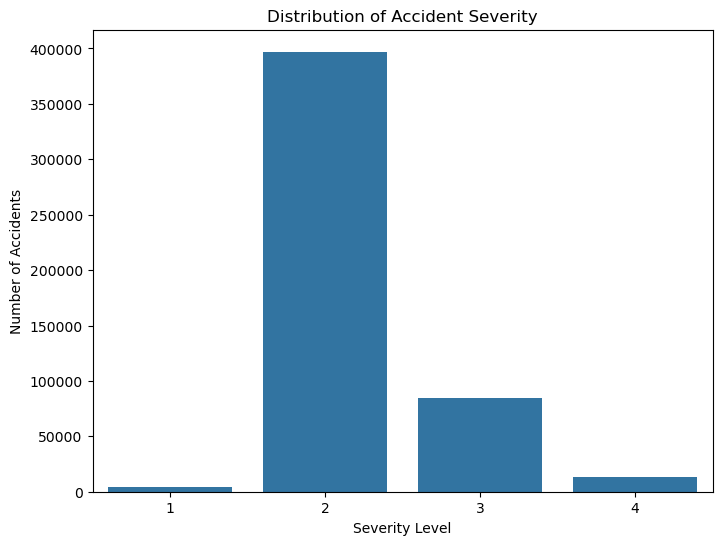

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(x='severity', data=accidents)
plt.title('Distribution of Accident Severity')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.show()

I'll create time series plots to visualize the number of accidents over different time intervals.

In [50]:
accidents['year'] = accidents['start_time'].dt.year

In [51]:
accidents_by_year = accidents.groupby('year')['id'].count().reset_index(name='accidents_count')
accidents_by_year

,year,accidents_count
0,2016,26656
1,2017,46483
2,2018,57505
3,2019,61746
4,2020,76041
5,2021,101498
6,2022,113149
7,2023,15704


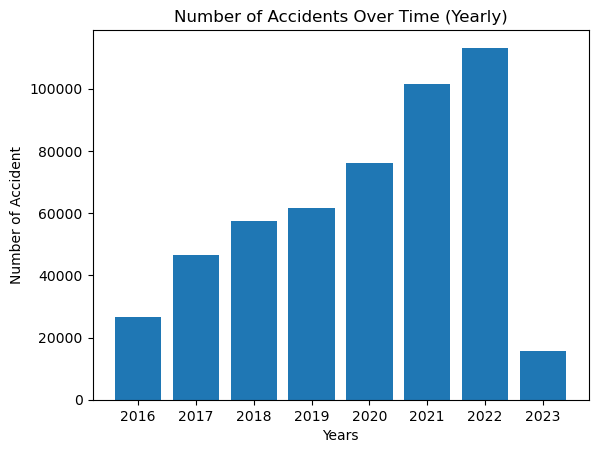

In [52]:
plt.bar(accidents_by_year['year'], accidents_by_year['accidents_count'])
plt.title("Number of Accidents Over Time (Yearly)")
plt.xlabel("Years")
plt.ylabel("Number of Accident")
plt.show()

I'll plot the number of accidents by hour of the day.

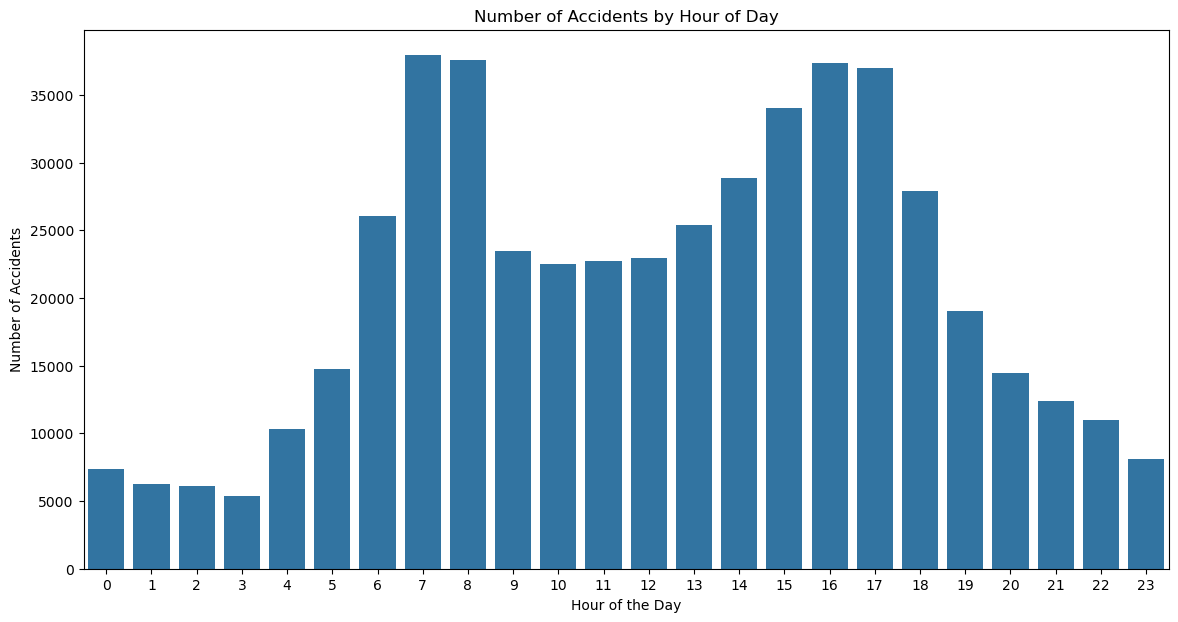

In [53]:
plt.figure(figsize=(14, 7))

accidents['hour'] = accidents['start_time'].dt.hour

sns.countplot(x='hour', data=accidents)
plt.title('Number of Accidents by Hour of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()

### Correlation Analysis

I'll calculate and visualize the correlations between numerical columns, particularly focusing on weather conditions and severity.

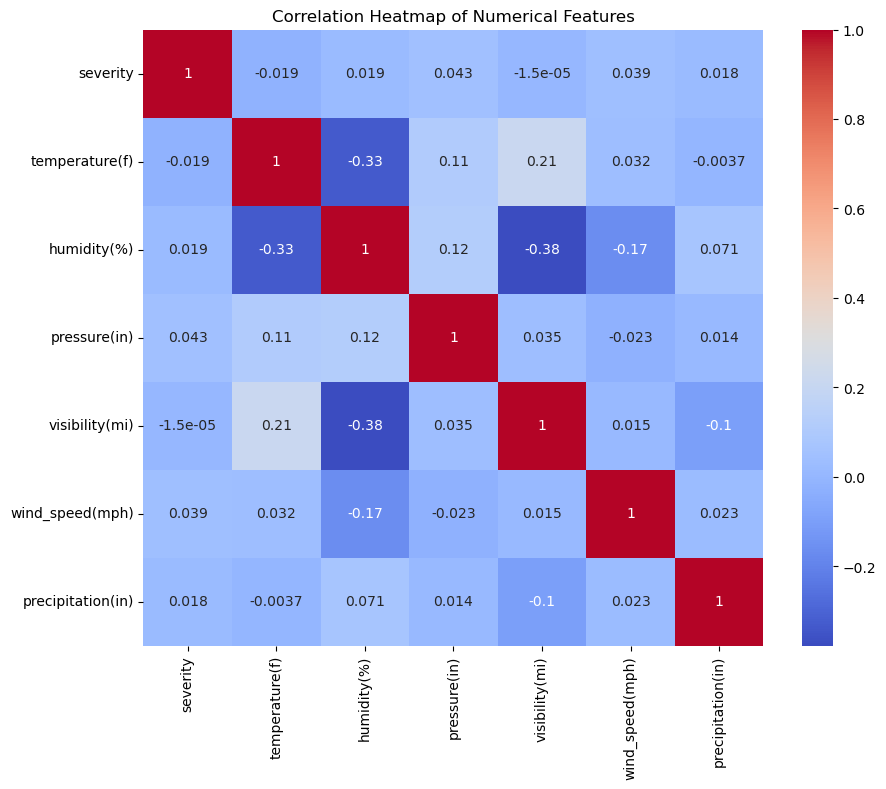

In [54]:
numerical_cols = ['severity', 'temperature(f)', 'humidity(%)', 'pressure(in)', 'visibility(mi)', 'wind_speed(mph)', 'precipitation(in)']

correlation_matrix = accidents[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## Merging the datasets

After I have carefully reviewed both data sources and gained a comprehensive understanding of the information they contain, I will be in a strong position to begin addressing any questions that arise. This deeper familiarity with the data will enable me to engage more effectively with the project, allowing me to explore the critical aspects in greater detail. At that point, I will be fully prepared to dive into the substantive work, analyze the key elements, and contribute meaningful insights to drive the project forward.

As understood from the beginning, the main goal of this project is to analyze and understand the impact of demographic and environmental factors on traffic accidents in the United States. The first important question, I asked myself <b>`How do demographic factors influence the frequency and severity of traffic accidents?`<b>

## Research question 1: How do demographic factors influence the frequency and severity of traffic accidents?

First of all I have to merge the two datasets. The two columns I will use for this are `'county'` and `'state'`

In [55]:
census['county']

0            Autauga County
1            Baldwin County
2            Barbour County
3               Bibb County
4             Blount County
               ...         
3215    Vega Baja Municipio
3216      Vieques Municipio
3217     Villalba Municipio
3218      Yabucoa Municipio
3219        Yauco Municipio
Name: county, Length: 3220, dtype: category
Categories (1955, object): ['Abbeville County', 'Acadia Parish', 'Accomack County', 'Ada County', ..., 'Yuma County', 'Zapata County', 'Zavala County', 'Ziebach County']

In [56]:
accidents['county']

0         East Baton Rouge
1                  Loudoun
2            Santa Barbara
3                    Mower
4                     Kern
                ...       
499995          Washington
499996          Palm Beach
499997             Yavapai
499998          Rockingham
499999            Hamilton
Name: county, Length: 498782, dtype: object

In [57]:
census['state']

0           Alabama
1           Alabama
2           Alabama
3           Alabama
4           Alabama
           ...     
3215    Puerto Rico
3216    Puerto Rico
3217    Puerto Rico
3218    Puerto Rico
3219    Puerto Rico
Name: state, Length: 3220, dtype: category
Categories (52, object): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', ..., 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

In [58]:
accidents['state']

0         LA
1         VA
2         CA
3         MN
4         CA
          ..
499995    OR
499996    FL
499997    AZ
499998    VA
499999    TN
Name: state, Length: 498782, dtype: object

As you can see `county` names and `state` abbreviations differ in format between the two datasets, I'll need to clean and standardize these fields before merging. Specifically, I'll want to:

1. Standardize the `county` names: Remove any additional text like "County" from the county column in the census.
2. Convert `state` names to abbreviations: Convert the full state names in the `census` to state abbreviations so they match the format in the `accidents` dataset.

In [59]:
# Clean the county names in the census dataset
census['county'] = census['county'].str.replace(' County', '')

In [60]:
# Convert full state names to state abbreviations
state_to_abbreviation = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia': 'DC',
    'Puerto Rico': 'PR'
}

In [61]:
# Convert state names to abbreviations (using map())
census['state'] = census['state'].map(state_to_abbreviation)

In [62]:
census['state']

0       AL
1       AL
2       AL
3       AL
4       AL
        ..
3215    PR
3216    PR
3217    PR
3218    PR
3219    PR
Name: state, Length: 3220, dtype: category
Categories (52, object): ['AL', 'AK', 'AZ', 'AR', ..., 'WA', 'WV', 'WI', 'WY']

To ensure consistency with the `census dataset`, which only includes data from 2017, I will `filter the accident dataset` (which contains data for multiple years) to retain only the 2017 records. This step aligns the timeframes of the two datasets for accurate analysis.

In [63]:
accidents = accidents.loc[accidents['year'] == 2017]

In [64]:
accidents.year

34        2017
44        2017
46        2017
48        2017
50        2017
          ... 
499914    2017
499967    2017
499968    2017
499973    2017
499981    2017
Name: year, Length: 46483, dtype: int32

I think I'm ready with the processing and I can merge them.

In [65]:
merged_df = pd.merge(accidents, census, on=['state', 'county'], how='left')

In [66]:
merged_df.head()

,id,source,severity,start_time,end_time,start_lat,start_lng,end_lat,end_lng,distance(mi),...,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment
0,A-3578098,Source1,2,2017-03-09 11:35:36,2017-03-09 17:35:36,33.968791,-84.526941,33.967254,-84.525474,0.135,...,1.2,2.0,7.6,31.4,382187.0,83.4,10.1,6.4,0.1,6.0
1,A-3628923,Source1,3,2017-06-12 13:25:50,2017-06-12 19:25:50,41.763640,-87.905380,41.772270,-87.906530,0.599,...,4.4,2.4,4.5,32.9,2521437.0,84.2,11.1,4.6,0.1,8.7
2,A-500188,Source2,2,2017-07-25 06:47:54,2017-07-25 07:47:43,34.066238,-84.292969,36.271446,-95.773771,0.000,...,2.6,1.9,8.2,28.1,500783.0,83.4,11.2,5.3,0.1,7.7
3,A-3591248,Source1,2,2017-03-15 08:31:59,2017-03-15 14:31:59,37.374690,-122.067810,37.380220,-122.067790,0.382,...,2.1,3.1,4.8,28.0,967294.0,84.7,9.3,5.9,0.1,5.7
4,A-463320,Source2,3,2017-06-26 11:38:48,2017-06-26 12:08:25,33.346985,-117.158836,36.271446,-95.773771,0.000,...,2.9,2.2,7.0,25.7,1536073.0,77.8,14.2,7.8,0.2,7.1


Before proceeding with the analysis, I will calculate the frequency of accidents per county. This step is crucial for understanding the distribution and concentration of accidents across different regions. By grouping the data by state and county and counting the number of accidents in each, I can identify areas with higher accident rates, which may require further investigation or targeted interventions. The resulting dataset will provide a clearer picture of accident patterns at a more localized level.

In [67]:
# Calculate the frequency of accidents per county
accident_counts = merged_df.groupby(['state', 'county']).size().reset_index(name='accident_count')

In [68]:
accident_counts

,state,county,accident_count
0,AL,Autauga,1
1,AL,Baldwin,5
2,AL,Barbour,1
3,AL,Blount,1
4,AL,Chambers,1
...,...,...,...
1320,WY,Carbon,1
1321,WY,Converse,1
1322,WY,Crook,1
1323,WY,Laramie,4


Let me identify the county with the highest number of accidents.

In [69]:
accident_counts[accident_counts['accident_count'] == accident_counts['accident_count'].max()]

,state,county,accident_count
51,CA,Los Angeles,3421


The output reveals that Los Angeles County in California has the highest number of accidents, with a total of 3,421 incidents. This indicates that Los Angeles County is a significant hotspot for accidents, potentially due to its large population, extensive road network, or other contributing factors.

In the next step, I will calculate the average accident severity for each county. This analysis will help determine which counties have more severe crashes on average, offering information on potential risk factors or hazardous conditions. In this way, I will be able to highlight regions where accidents are more severe, which may serve as a basis for future safety measures or resource allocation.

In [70]:
severity_means = merged_df.groupby(['county', 'state'])['severity'].mean().reset_index(name='mean_severity')

In [71]:
severity_means

,county,state,mean_severity
0,Abbeville,SC,2.000000
1,Acadia,LA,3.000000
2,Accomack,VA,2.000000
3,Adair,IA,2.333333
4,Adams,CO,2.466667
...,...,...,...
1320,York,SC,2.375000
1321,York,VA,2.571429
1322,Yuba,CA,2.000000
1323,Yuma,AZ,3.000000


Now, I will merge the accident counts and severity means with the demographic data from the census dataset. By combining these datasets, I can gain deeper insights into how demographic characteristics might influence accident patterns and severity, leading to more comprehensive findings and potentially informing targeted interventions.

In [72]:
accident_analysis_df = pd.merge(accident_counts, severity_means, on=['county', 'state'])
accident_analysis_df = pd.merge(accident_analysis_df, census, on=['county', 'state'])

In [73]:
accident_analysis_df

,state,county,accident_count,mean_severity,county_id,total_pop,men,women,hispanic,white,...,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment
0,AL,Autauga,1,3.0,1001,55036,26899,28137,2.7,75.4,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,AL,Baldwin,5,2.8,1003,203360,99527,103833,4.4,83.1,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,AL,Barbour,1,2.0,1005,26201,13976,12225,4.2,45.7,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,AL,Blount,1,2.0,1009,57667,28490,29177,9.0,87.4,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9
4,AL,Chambers,1,2.0,1017,33895,16320,17575,2.2,56.2,...,0.6,0.5,2.0,23.6,14527,84.5,11.8,3.7,0.0,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,WY,Carbon,1,2.0,56007,15689,8456,7233,17.9,77.7,...,3.5,1.4,4.1,16.3,7519,70.3,24.9,4.3,0.4,3.4
1236,WY,Converse,1,4.0,56009,14166,7279,6887,7.8,91.3,...,2.9,1.6,6.2,23.8,6902,74.5,17.8,7.6,0.2,5.8
1237,WY,Crook,1,2.0,56011,7347,3760,3587,2.3,94.5,...,4.0,2.6,13.4,28.0,3613,73.0,16.4,10.5,0.2,3.6
1238,WY,Laramie,4,2.5,56021,97031,49218,47813,14.3,79.1,...,2.6,1.5,3.8,15.8,47243,68.2,26.2,5.3,0.3,5.3


### Correlation Analysis

`Understanding which demographic factors correlate with traffic accidents.`

I will calculate the correlation coefficients between accident_count and mean_severity with each of the demographic factors. 
This will help me determine the strength and direction of the relationship (positive or negative).
The aim is to identify which demographic factors are most strongly associated with accident frequency 
(accident_count) and severity (mean_severity).
High positive or negative correlations suggest a strong relationship. For instance, a high positive correlation between 
poverty and accident_count might indicate that areas with higher poverty rates experience more traffic accidents.

In [74]:
correlation_matrix = accident_analysis_df[['accident_count', 'mean_severity', 
                                           'total_pop', 'income', 'poverty', 
                                           'child_poverty', 'mean_commute', 
                                           'unemployment']].corr()
correlation_matrix

,accident_count,mean_severity,total_pop,income,poverty,child_poverty,mean_commute,unemployment
accident_count,1.000000,-0.114973,0.847519,0.144071,-0.019864,-0.014067,0.121709,0.023059
mean_severity,-0.114973,1.000000,-0.131579,-0.120945,0.042959,0.064245,-0.070717,-0.045188
total_pop,0.847519,-0.131579,1.000000,0.229672,-0.044906,-0.044277,0.181690,0.033048
income,0.144071,-0.120945,0.229672,1.000000,-0.779047,-0.759626,0.354488,-0.478479
poverty,-0.019864,0.042959,-0.044906,-0.779047,1.000000,0.929193,-0.178257,0.657075
child_poverty,-0.014067,0.064245,-0.044277,-0.759626,0.929193,1.000000,-0.114650,0.656092
mean_commute,0.121709,-0.070717,0.181690,0.354488,-0.178257,-0.114650,1.000000,0.067487
unemployment,0.023059,-0.045188,0.033048,-0.478479,0.657075,0.656092,0.067487,1.000000


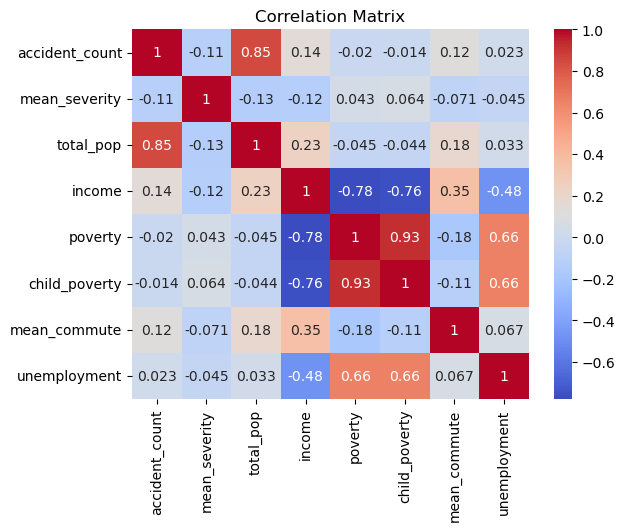

In [75]:
# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Here's a summary of the key findings from the correlation matrix:**
- `Accident Count:` **Strongly positively correlated with `total_pop (0.85)`**, suggesting that areas with larger populations tend to have more accidents. It shows a **weak negative correlation with `mean_severity (-0.11)`**, indicating that accident severity is not strongly linked to the number of accidents.
- `Mean Severity:` Shows **weak correlations with most variables** but has a notable **positive correlation with `poverty (0.04)` and `child_poverty (0.06)`**. This implies that while the relationships are not strong, there might be some association between higher severity and areas with higher poverty or child poverty rates.
- `Income:` **Strongly negatively correlated with `poverty (-0.78)` and `child_poverty (-0.76)`**, suggesting that higher income areas generally have lower poverty and child poverty rates.
- `Poverty and Child Poverty:` **Both are highly positively correlated (0.93)**, indicating that areas with higher poverty rates also tend to have higher child poverty rates.
- `Unemployment:` Shows a **moderate positive correlation with `poverty (0.66)` and `child_poverty (0.66)`**, suggesting that higher unemployment is associated with higher poverty and child poverty.

### Comparative Analysis

`Compare accidents between counties with differing demographics.`

In the next step, I will compare accident statistics between high-income and low-income counties. By dividing the counties based on their income relative to the median, I can analyze how income levels influence accident frequency and severity. This comparison will help identify any significant differences in accident patterns between wealthier and less affluent areas, providing insights into how income may impact road safety and accident outcomes.

In [76]:
# Compare high vs low income counties
high_income = accident_analysis_df[accident_analysis_df['income'] > accident_analysis_df['income'].median()]
low_income = accident_analysis_df[accident_analysis_df['income'] <= accident_analysis_df['income'].median()]

comparison = pd.DataFrame({
    'High Income': [high_income['accident_count'].mean(), high_income['mean_severity'].mean()],
    'Low Income': [low_income['accident_count'].mean(), low_income['mean_severity'].mean()]
}, index=['accident_count', 'mean_severity'])

comparison

,High Income,Low Income
accident_count,57.359677,14.209677
mean_severity,2.645039,2.760667


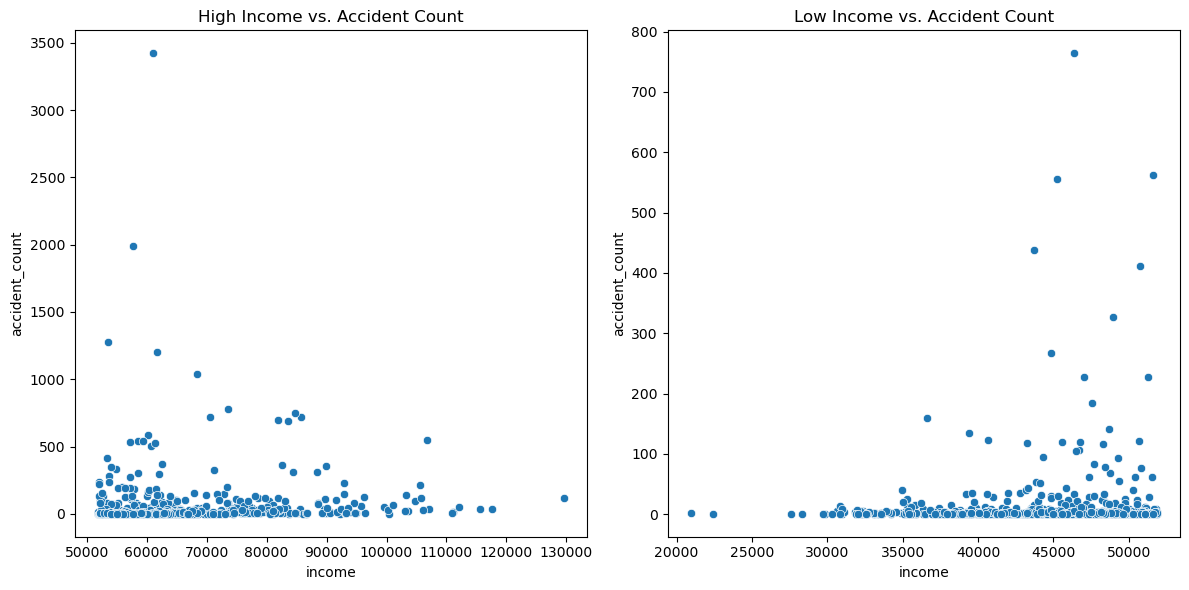

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=high_income, x='income', y='accident_count', ax=axes[0])
axes[0].set_title('High Income vs. Accident Count')

sns.scatterplot(data=low_income, x='income', y='accident_count', ax=axes[1])
axes[1].set_title('Low Income vs. Accident Count')

plt.tight_layout()
plt.show()

The comparison between high-income and low-income counties reveals that high-income areas have a higher average number of accidents (57.36) compared to low-income areas (14.21). Despite this, the average severity of accidents is slightly lower in high-income counties (2.65) than in low-income counties (2.76). This suggests that while affluent regions experience more accidents, these incidents are somewhat less severe on average. The differences may reflect variations in road infrastructure, vehicle safety, or emergency response between income levels.

## Research Question 2: What is the Impact of Weather Conditions on Accident Rates Across Different Counties?

In this part of my project, I explore how various weather conditions impact traffic accident rates across different counties in the United States. My focus is on determining whether adverse weather, such as rain, snow, and fog, leads to increased accident rates compared to clear weather conditions.
I expect to find that counties experiencing frequent severe weather conditions have higher accident rates. These findings could help inform targeted safety measures and road safety policies in regions most affected by adverse weather.

Now, I will convert the `weather_timestamp` column from its original string format to datetime format. This conversion will enable more effective and insightful analysis of how traffic accidents correlate with different weather conditions over time.

In [78]:
merged_df['weather_timestamp'] = pd.to_datetime(merged_df['weather_timestamp'])

Next, I will calculate the total number of accidents for each county:

In [79]:
accidents_by_county = merged_df.groupby(['county', 'state']).size().reset_index(name='accident_count')

I grouped the data by `county` and `state` to aggregate all accident records for each county. I used the `.size()` method to count the number of accidents per county and stored it in a new column called `accident_count`. This step summarizes the accident data by county, providing a foundation for further analysis of accident rates and their influencing factors.

In [80]:
accidents_by_county.head()

,county,state,accident_count
0,Abbeville,SC,15
1,Acadia,LA,1
2,Accomack,VA,2
3,Adair,IA,3
4,Adams,CO,60


As next step I will group the data by `county`, `state`, and `weather_condition` to determine how many accidents occurred under each type of weather condition for each county. By counting the number of accidents in each group using the `.size()` method, I will generate a new DataFrame that shows the number of accidents associated with each weather condition. This step is crucial for understanding how different weather conditions contribute to accident rates across various counties.

In [81]:
weather_impact = merged_df.groupby(['county', 'state', 'weather_condition']).size().reset_index(name='accident_count')

After creating the `weather_impact` DataFrame, I'll use the following code to determine the combination of weather conditions and county with the highest number of accidents:

In [82]:
weather_impact[weather_impact['accident_count'] == weather_impact['accident_count'].max()]

,county,state,weather_condition,accident_count
2570,Los Angeles,CA,Clear,2079


The analysis revealed that the highest number of accidents occurred in `Los Angeles County, CA`, with a total of `2079` accidents under `Clear` weather conditions. This indicates that, despite the favorable weather, Los Angeles experienced the most significant accident count, highlighting the need for focused traffic safety measures in this area.

For the next step, I will merge the `weather_impact` dataset with the `accidents_by_county` dataset to calculate the `accident rate` for each weather condition:

In [83]:
weather_impact = pd.merge(weather_impact, accidents_by_county, on=['county', 'state'], suffixes=('_weather', '_total'))

This merge allows for calculating the accident rate for each weather condition by dividing the number of accidents in each weather category by the total number of accidents in the respective county. This calculation helps in understanding how different weather conditions impact accident rates across counties.

In [84]:
weather_impact.head(10)

,county,state,weather_condition,accident_count_weather,accident_count_total
0,Abbeville,SC,Clear,5,15
1,Abbeville,SC,Fair,1,15
2,Abbeville,SC,Fog,2,15
3,Abbeville,SC,Mist,1,15
4,Abbeville,SC,Mostly Cloudy,1,15
5,Abbeville,SC,Overcast,3,15
6,Abbeville,SC,Partly Cloudy,1,15
7,Abbeville,SC,Scattered Clouds,1,15
8,Acadia,LA,Clear,1,1
9,Accomack,VA,Overcast,2,2


I can now calculate the percentage of accidents that occurred in each weather condition in each county:

In [85]:
weather_impact['accident_rate'] = (weather_impact['accident_count_weather'] / weather_impact['accident_count_total']) * 100

This percentage (`accident_rate`) represents the proportion of accidents that occurred under each weather condition relative to the total number of accidents in the county. This metric is crucial for understanding the relative impact of different weather conditions on traffic safety in each county.

In [86]:
weather_impact[['county', 'state', 'weather_condition', 'accident_rate']]

,county,state,weather_condition,accident_rate
0,Abbeville,SC,Clear,33.333333
1,Abbeville,SC,Fair,6.666667
2,Abbeville,SC,Fog,13.333333
3,Abbeville,SC,Mist,6.666667
4,Abbeville,SC,Mostly Cloudy,6.666667
...,...,...,...,...
4798,York,VA,Overcast,14.285714
4799,Yuba,CA,Clear,87.500000
4800,Yuba,CA,Fog,12.500000
4801,Yuma,AZ,Clear,50.000000


An important thing to understand is which weather conditions are associated with the highest number of accidents, which will help me identify the most dangerous conditions. To figure this out I will group the data by `weather_condition` and sum the total number of incidents for each condition.

In [87]:
total_accidents_by_weather = weather_impact.groupby('weather_condition')['accident_count_weather'].sum().reset_index()

Now, i have to sort the results in descending order to see the weather conditions with the most accidents

In [88]:
total_accidents_by_weather = total_accidents_by_weather.sort_values(by='accident_count_weather', ascending=False).reset_index()

print("Weather conditions with the most accidents:")
total_accidents_by_weather.head(10)

Weather conditions with the most accidents:


,index,weather_condition,accident_count_weather
0,0,Clear,16958
1,29,Overcast,7477
2,27,Mostly Cloudy,6816
3,30,Partly Cloudy,4636
4,34,Scattered Clouds,4389
5,21,Light Rain,2161
6,24,Light Snow,527
7,32,Rain,491
8,8,Haze,470
9,6,Fog,244


Hmmm, the analysis shows that `Clear` weather conditions, surprisingly, have the highest number of accidents, with a total of 159,235 incidents. This finding suggests that clear and seemingly safe weather doesn't necessarily lead to fewer accidents. Drivers might be less cautious or face higher traffic volumes during fair weather, contributing to the higher accident count. This emphasizes that road safety should be a priority in all weather conditions, not just during adverse weather.

## Hypotheses Related to Time Series Data

### Seasonal Variations in Accident Rates

Traffic accident rates exhibit significant seasonal variations, with higher accident rates observed during specific seasons (e.g., summer and winter) due to changes in weather and travel behavior. Different seasons can impact driving conditions and travel patterns, potentially influencing accident rates.

Let's define seasons based on the month.

In [89]:
merged_df['month'] = merged_df['weather_timestamp'].dt.month

In [90]:
"""
    Determine the season based on the given month.

    Parameters:
    month (int): An integer representing the month (1 for January, 2 for February, etc.).

    Returns:
    str: The name of the season corresponding to the given month. The seasons are categorized as:
        - 'Winter': December (12), January (1), February (2)
        - 'Spring': March (3), April (4), May (5)
        - 'Summer': June (6), July (7), August (8)
        - 'Autumn': September (9), October (10), November (11)
"""

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"

merged_df['season'] = merged_df['month'].apply(get_season)

Now, let me aggregate the results by season.

In [91]:
accidents_by_season = merged_df.groupby('season')['id'].count().reset_index(name='accident_count')
accidents_by_season

,season,accident_count
0,Autumn,14187
1,Spring,9454
2,Summer,10912
3,Winter,11387


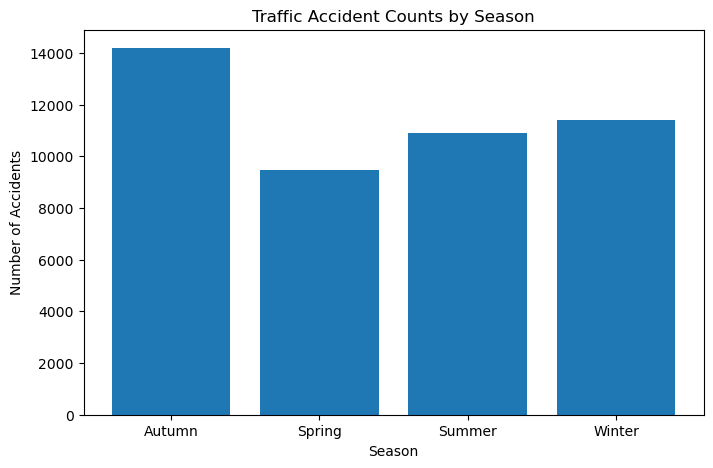

In [92]:
plt.figure(figsize=(8, 5))

seasons = accidents_by_season['season']
number_of_accidents_by_season= accidents_by_season['accident_count']

plt.bar(seasons, number_of_accidents_by_season)

plt.title('Traffic Accident Counts by Season')
plt.xlabel('Season')
plt.ylabel('Number of Accidents')

plt.show()

The data reveals that Autumn has the highest number of accidents, followed by Winter, Summer, and Spring, which has the lowest accident count. This finding is somewhat unexpected, as one might intuitively assume that summer, with its increased travel and vacation traffic, would have the highest accident rates.
This elevated accident rate in autumn could be attributed to several factors:
1. `Increased Traffic:` The return to school increases traffic volumes as families adjust their routines, leading to more potential for accidents.
2. `Challenging Weather:` Autumn often brings wet conditions and shorter daylight hours, which can impair driving conditions and safety.
3. `Seasonal Transitions:` Drivers may be less prepared for the changing weather, leading to more accidents.
4. `Holiday Traffic:` Autumn holidays, like Halloween and Thanksgiving, contribute to increased travel and, consequently, higher accident rates.

### Daily and Weekly Patterns

Traffic accidents show distinct daily and weekly patterns, with higher accident frequencies observed during weekdays compared to weekends and during peak traffic hours (e.g., morning and evening rush hours).
Traffic volumes and driving behavior often vary by day of the week and time of day, which might affect accident rates.

In [93]:
# Extract day of the week
merged_df['day_of_week'] = merged_df['start_time'].dt.day_name()

In [94]:
accidents_by_day = merged_df.groupby('day_of_week')['id'].count().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index(name='accident_count')
accidents_by_day

,day_of_week,accident_count
0,Monday,7829
1,Tuesday,8306
2,Wednesday,8501
3,Thursday,8512
4,Friday,8970
5,Saturday,2296
6,Sunday,2069


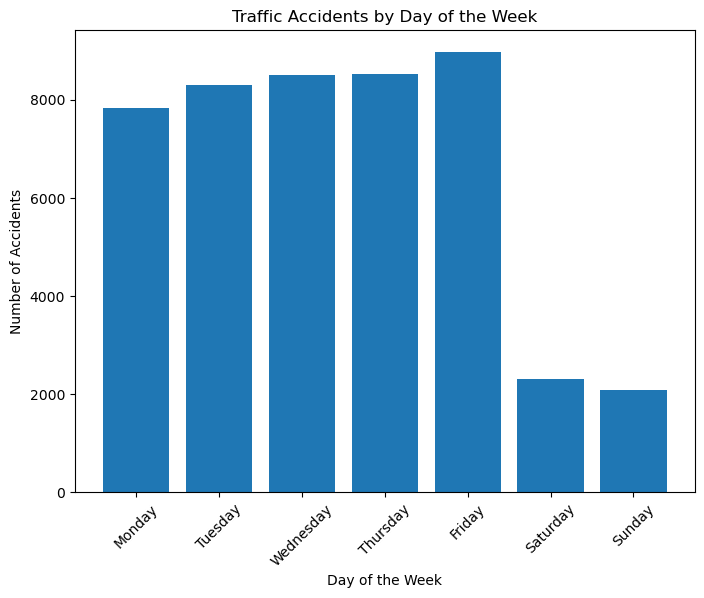

In [95]:
plt.figure(figsize=(8, 6))
day = accidents_by_day['day_of_week']
acc_count = accidents_by_day['accident_count']

plt.bar(day, acc_count)
plt.title('Traffic Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

The data shows that traffic accidents are significantly more frequent on weekdays, with the highest counts observed on `Fridays (8,975 accidents)`, followed by Thursday (8,516) and Wednesday (8,512). Sundays and Saturdays have the lowest accident counts, with 2,069 and 2,299 accidents, respectively.

<b>Possible reasons:<b>
1. `Increased Weekday Traffic:` Weekdays generally have higher traffic volumes due to work commutes, school runs, and regular business activities, leading to more accidents.
2. `Friday Spike:` The spike on Fridays could be due to end-of-week fatigue, rush to start the weekend, or increased social activities.
3. `Lower Weekend Traffic:` Fewer accidents on weekends likely result from reduced commuter traffic and more relaxed driving conditions.

We saw what happens on a daily basis, and now it's time to analyze traffic accidents on an hourly scale. By examining accident frequencies for each hour of the day, I can identify the specific times when accidents are most common. This hourly analysis will provide a detailed view of how traffic patterns and driving behavior contribute to accident risks throughout the day, helping to pinpoint the most dangerous times on the road.

In [96]:
accidents_by_hour = merged_df.groupby('hour')['id'].count().reset_index(name='accident_count')
accidents_by_hour

,hour,accident_count
0,0,359
1,1,299
2,2,333
3,3,287
4,4,672
5,5,1124
6,6,2385
7,7,3893
8,8,4195
9,9,2758


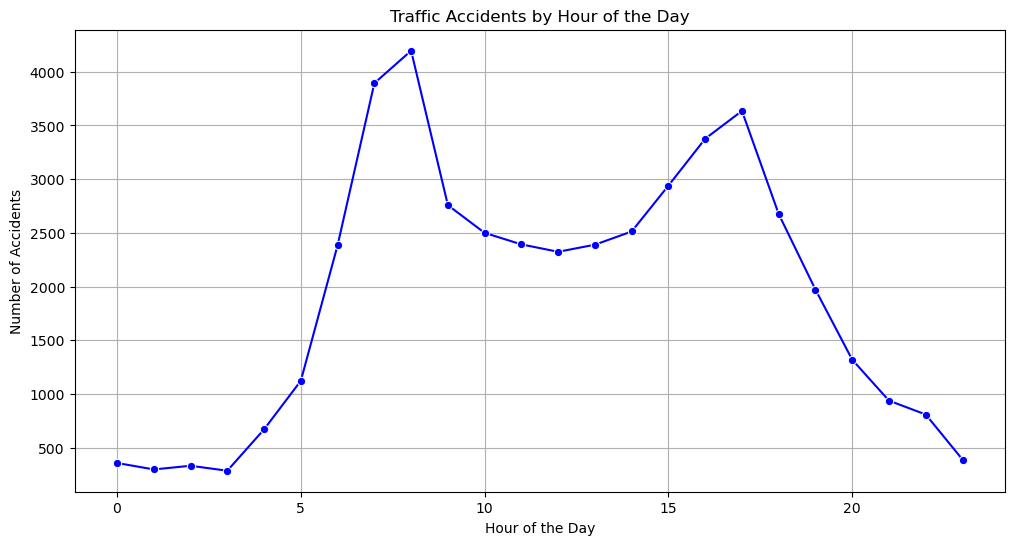

In [97]:
# Plot hourly patterns
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='accident_count', data=accidents_by_hour, marker='o', color='blue')
plt.title('Traffic Accidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

Hm, let's see what happens here. I will divide the day into 4 parts:
1. <b>Morning Rush Hour (6 AM - 9 AM):</b> Accidents rise sharply starting at 6 AM, `peaking at 8 AM (4,202 accidents)`, coinciding with the morning commute when roads are most congested.
2. <b>Midday Stability (10 AM - 2 PM):</b> After the morning peak, accident rates <b>stabilize</b>, suggesting safer driving conditions with steady traffic flows.
3. <b>Evening Rush Hour (4 PM - 6 PM):</b> A second peak occurs between 4 PM and 6 PM, with a high at `5 PM (3,641 accidents)`, reflecting the evening commute and increased road congestion.
4. <b>Late Evening Decline (7 PM - Midnight):</b> Accidents <b>decrease</b> significantly after 7 PM, reaching their `lowest levels between midnight and 5 AM`, when traffic is light but risks from fatigue and reduced visibility are higher.

<b>Possible Reasons:</b><br>
The spikes during rush hours are likely due to high traffic volumes, stress, and hurry, increasing the chances of collisions. The midday stability reflects balanced traffic and safer driving conditions, while the late evening decline is linked to fewer vehicles on the road, despite higher risks for those driving. This analysis highlights the need for targeted road safety measures during peak traffic times.

### Effect of Time of Day on Accident Severity:

The severity of traffic accidents varies by time of day, with more severe accidents occurring during late-night hours compared to daytime hours. Reduced visibility and driver fatigue during late-night hours could contribute to more severe accidents.

In [98]:
"""
    Categorizes a given hour into one of four time-of-day periods.

    Parameters:
    -----------
    hour : int
        The hour of the day (0-23) as an integer, where 0 represents midnight and 23 represents 11 PM.

    Returns:
    --------
    str
        A string representing the time of day:
        - 'Late Night' for hours between 12 AM (midnight) and 5:59 AM
        - 'Morning' for hours between 6 AM and 11:59 AM
        - 'Afternoon' for hours between 12 PM (noon) and 5:59 PM
        - 'Evening' for hours between 6 PM and 11:59 PM
"""

def time_of_day(hour):
    if hour >= 0 and hour < 6:
        return 'Late Night'
    elif hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [99]:
merged_df['time_of_the_day'] = merged_df['hour'].apply(time_of_day)

In [100]:
merged_df['time_of_the_day']

0           Morning
1         Afternoon
2           Morning
3           Morning
4           Morning
            ...    
46478     Afternoon
46479     Afternoon
46480       Evening
46481       Evening
46482    Late Night
Name: time_of_the_day, Length: 46483, dtype: object

In [101]:
severity_by_time = merged_df.groupby('time_of_the_day')['severity'].mean().reset_index()
severity_by_time

,time_of_the_day,severity
0,Afternoon,2.377983
1,Evening,2.454792
2,Late Night,2.570267
3,Morning,2.343964


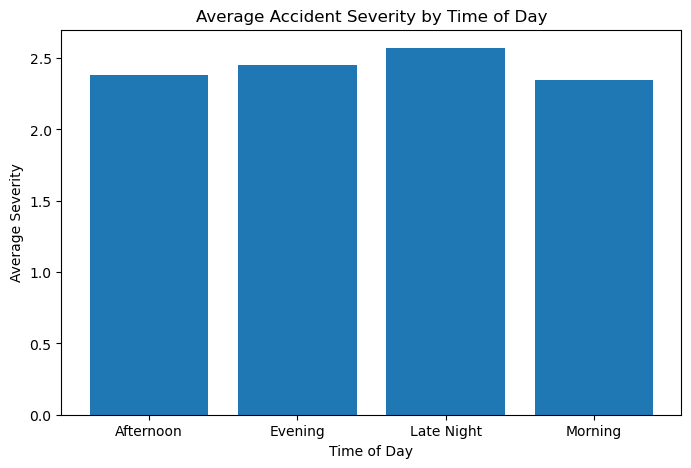

In [102]:
plt.figure(figsize=(8, 5))

time = severity_by_time['time_of_the_day']
severity = severity_by_time['severity']

plt.bar(time, severity)
plt.title('Average Accident Severity by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Severity')

plt.show()

The data indicates that traffic accidents tend to be <b>more severe</b> during `Late Night hours`, with an average severity of 2.57, followed by the Evening (2.46). Accidents are least severe in the Morning (2.34).

<b>Possible Reasons:</b>
1. <b>Late Night:</b> `Higher severity during late-night hours` could be due to factors like reduced visibility, driver fatigue, and impaired driving (e.g., alcohol consumption), which increase the likelihood of more severe accidents.
2. <b>Evening:</b> The evening period sees `higher severity` likely due to a combination of heavy traffic, rush hour stress, and reduced light conditions as night approaches.
3. <b>Morning and Afternoon:</b> `Lower severity in the morning and afternoon` might be attributed to better visibility, more alert drivers, and less risky driving behaviors during daylight hours.

In conclusion, the time of day has a significant impact on the severity of accidents, with late night driving posing the greatest risks.

### Impact of Daylight on Accident Rates:

The impact of daylight on traffic accident rates is a crucial aspect to consider when analyzing road safety. Daylight hours are generally associated with better visibility and safer driving conditions, which could influence both the frequency and severity of accidents. This section explores whether traffic accidents are less frequent and less severe during daylight hours compared to nighttime, considering factors like traffic volume, visibility, and driver behavior. By examining accident data across different times of the day, we aim to understand how daylight affects road safety outcomes.

**Hypothesis:** Traffic accidents are less frequent and less severe during daylight hours compared to nighttime hours, due to improved visibility and safer driving conditions. <br>
**Rationale:** Daylight improves visibility, potentially reducing both the frequency and severity of accidents.

In [103]:
 """
    Determines whether a given hour corresponds to daylight or nighttime.

    Parameters:
    -----------
    hour : int
        The hour of the day (0-23) in 24-hour format.

    Returns:
    --------
    str
        'Daylight' if the hour is between 6 AM and 6 PM (inclusive of 6 AM, exclusive of 6 PM),
        'Nighttime' otherwise.
"""

def daylight_or_night(hour):
    if hour >= 6 and hour < 18:
        return 'Daylight'
    else:
        return 'Nighttime'

merged_df['daylight'] = merged_df['hour'].apply(daylight_or_night)

In [104]:
accidents_by_daylight = merged_df.groupby('daylight').size().reset_index(name="accident_count")
accidents_by_daylight

,daylight,accident_count
0,Daylight,35302
1,Nighttime,11181


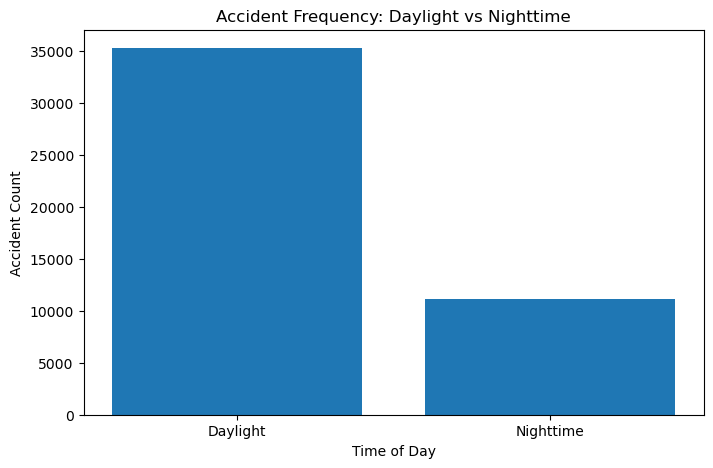

In [105]:
plt.figure(figsize=(8, 5))

daylight_or_not = accidents_by_daylight['daylight']
acc_count = accidents_by_daylight['accident_count']

plt.bar(daylight_or_not, acc_count)
plt.title('Accident Frequency: Daylight vs Nighttime')
plt.xlabel('Time of Day')
plt.ylabel('Accident Count')
plt.show()

A significantly <b>higher</b> number of traffic accidents occur during `Daylight` hours (35,327 accidents) compared to `Nighttime` hours (11,187 accidents).

<b>Possible Reasons:</b>
1. <b>Higher Traffic Volumes:</b> Daylight hours coincide with peak traffic periods, including morning and evening commutes, which increases the likelihood of accidents.
2. <b>Increased Activity:</b> More people are on the roads during the day due to work, school, and other daily activities, leading to more opportunities for collisions.
3. <b>Nighttime Driving:</b> Although fewer accidents happen at night, driving conditions are more dangerous due to reduced visibility, fatigue, and higher chances of impaired driving, which could lead to more severe accidents.

To assess how daylight affects accident severity, the next step will involve calculating the average severity of accidents during Daylight and Nighttime hours. This analysis will help determine if nighttime accidents are more severe, possibly due to factors like reduced visibility and driver fatigue.

In [106]:
severity_by_daylight = merged_df.groupby('daylight')['severity'].mean().reset_index()
severity_by_daylight

,daylight,severity
0,Daylight,2.360518
1,Nighttime,2.486540


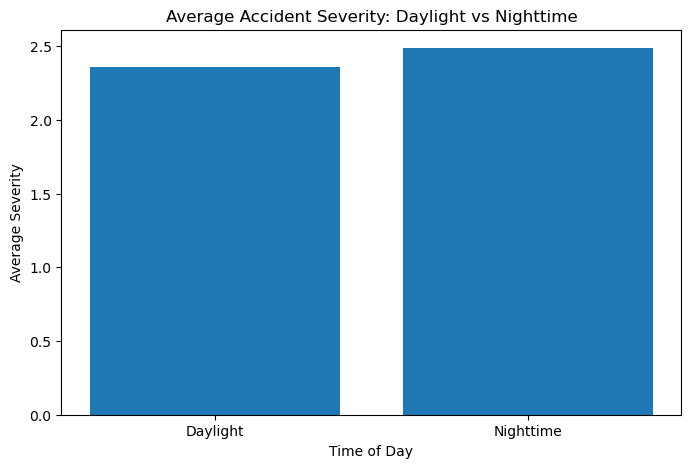

In [107]:
plt.figure(figsize=(8, 5))
plt.bar(severity_by_daylight['daylight'], severity_by_daylight['severity'])
plt.title('Average Accident Severity: Daylight vs Nighttime')
plt.xlabel('Time of Day')
plt.ylabel('Average Severity')
plt.show()

The data indicates that traffic accidents are, on average, more severe during Nighttime hours, with a severity score of 2.49, compared to 2.36 during Daylight hours.

<b>Possible Reasons:</b>
1. <b>Reduced Visibility:</b> Lower visibility at night makes it harder for drivers to see obstacles and react in time, leading to more severe collisions.</b>
2. <b>Driver Fatigue:</b> Fatigue is more common during nighttime, which can impair reaction times and decision-making, increasing the severity of accidents.
3. <b>Impaired Driving:</b> There is a higher likelihood of impaired driving at night due to alcohol or drug use, contributing to more severe accidents.

As an `overall conclusion`, the hypothesis is **partially correct**. While it was expected that traffic accidents would be less frequent during daylight hours, the data reveals that accidents are actually more common during the day. This can be explained by the higher traffic volumes associated with daytime activities like commuting, work, and school. However, the hypothesis is accurate in predicting that accidents are less severe during daylight hours. The findings show that nighttime accidents tend to be more severe, likely due to factors such as reduced visibility, driver fatigue, and a greater likelihood of impaired driving. Thus, the hypothesis is validated for accident severity but not for accident frequency.

### How do specific road conditions (e.g., presence of bumps, crossings, traffic signals, and junctions) influence the frequency and severity of traffic accidents across U.S. counties?"

Traffic crashes pose a serious safety challenge in the United States, with road conditions playing a critical role in their frequency and severity. Elements such as bump-outs, intersections, traffic signs, and crosswalks are intended to improve safety, but their impact can vary. In this study, I will investigate how these specific roadway conditions affect the occurrence and severity of traffic crashes in U.S. counties, with the goal of discovering patterns that could guide more effective road safety measures.

**Hypothesis:**
Counties with more traffic control measures such as traffic signals, bumps, and well-marked crossings will have a lower frequency of severe traffic accidents compared to counties with fewer such measures. Conversely, road conditions like multiple junctions and the absence of these controls will be associated with higher accident severity. <br>
**Rationale:**
Road conditions and traffic controls are key factors in traffic safety. Features like traffic signals, bumps, and crossings help manage traffic flow and reduce accidents by controlling speed and clarifying right-of-way. Conversely, complex conditions like multiple junctions or insufficient traffic controls can raise accident risks due to driver confusion or lack of guidance.

#### Frequency

To investigate the impact of road conditions on traffic accidents, I will first analyze the frequency of accidents associated with four key features: <b>bump-outs, crossings, traffic signals, and junctions.</b> These elements play crucial roles in traffic management and safety.

In [108]:
# I will focus on specific road condition columns
road_conditions = ['bump', 'crossing', 'traffic_signal', 'junction']

In [109]:
total_accident_frequency = merged_df[road_conditions].sum().reset_index()
total_accident_frequency.columns = ['Road Condition', 'Accident Count']
total_accident_frequency

,Road Condition,Accident Count
0,bump,13
1,crossing,6437
2,traffic_signal,9975
3,junction,4193


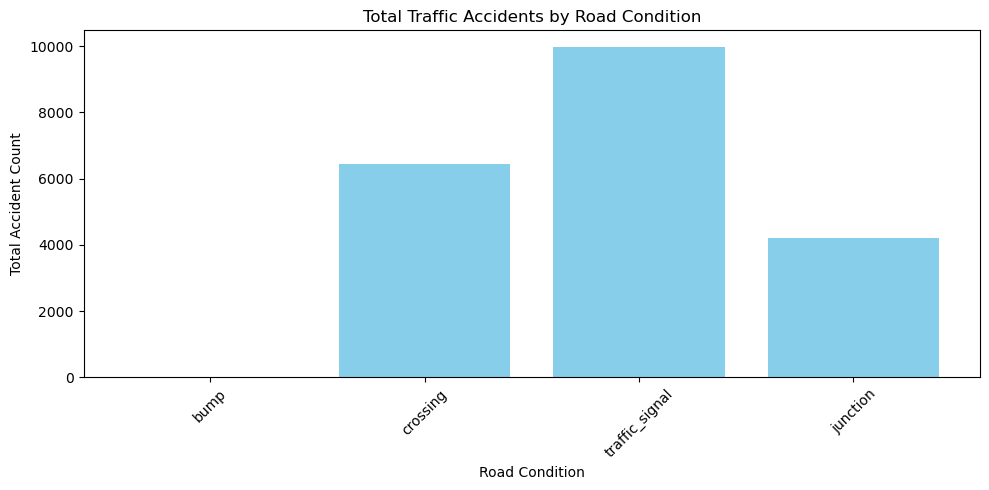

In [110]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(total_accident_frequency['Road Condition'], total_accident_frequency['Accident Count'], color='skyblue')
ax.set_xlabel('Road Condition')
ax.set_ylabel('Total Accident Count')
ax.set_title('Total Traffic Accidents by Road Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The analysis reveals significant variability in the frequency of traffic accidents related to different road conditions:
- **Bump: 13 accidents**
- **Crossing: 6,438 accidents**
- **Traffic Signal: 9,977 accidents**
- **Junction: 4,196 accidents**

1. `Traffic Signals` are associated with the highest number of accidents, totaling **9,977.** This could be attributed to the high number of intersections controlled by traffic signals, which often experience complex driving behaviors and increased traffic volume.
2. `Crossings` also show a substantial number of accidents, with **6,438 incidents.** Crossings are critical points where traffic flows intersect, which can lead to increased accident risk due to conflicting movements and reduced visibility.
3. `Junctions` account for **4,196 accidents.** Similar to traffic signals and crossings, junctions are complex traffic control points where multiple roads meet, leading to potential confusion and higher accident rates.
4. `Bumps` have the lowest accident count, with only **13 incidents.** This relatively low number suggests that while bumps may contribute to accidents, they are less frequent compared to other road conditions. This might be due to their less complex nature and the fact that they are often well-marked to alert drivers.

In conclusion, the high number of accidents at traffic lights and junctions highlights them as key areas for safety improvement. Improving signal timing, visibility and driver training can reduce accidents at these locations. Junctions also pose a significant risk due to their complexity; better signage, road design and control are needed. Although bumps are associated with fewer accidents, maintaining and clearly marking them is still important. Prioritising safety measures at traffic signals, junctions and intersections could effectively reduce the number of crashes, with further analysis needed for targeted interventions.

#### Severity 

<b>Let's start by answering the question about the severity.</b> As a first step, I will summarize the crash data at the county and state level by calculating the average severity of crashes according to these roadway characteristics. By grouping the data by county and analyzing the average crash severity for each road condition, I aim to discover whether certain conditions are associated with higher or lower crash severity.

In [111]:
severity = 'severity'

road_condition_severity = merged_df.groupby(['state', 'county'])[road_conditions + [severity]].mean().reset_index()

road_condition_severity

,state,county,bump,crossing,traffic_signal,junction,severity
0,AL,Autauga,0.0,0.0,0.0,0.00,3.0
1,AL,Baldwin,0.0,0.0,0.0,0.20,2.8
2,AL,Barbour,0.0,0.0,0.0,0.00,2.0
3,AL,Blount,0.0,0.0,0.0,0.00,2.0
4,AL,Chambers,0.0,0.0,0.0,0.00,2.0
...,...,...,...,...,...,...,...
1320,WY,Carbon,0.0,0.0,0.0,0.00,2.0
1321,WY,Converse,0.0,0.0,0.0,0.00,4.0
1322,WY,Crook,0.0,0.0,0.0,0.00,2.0
1323,WY,Laramie,0.0,0.0,0.0,0.25,2.5


The data shows that `many counties have 0 or near-zero values` for road conditions like bumps, crossings, and traffic signals. Since we can't view all observations here, <b>scatter plots</b> would be helpful to better visualize the relationship between these road conditions and accident severity across all counties.

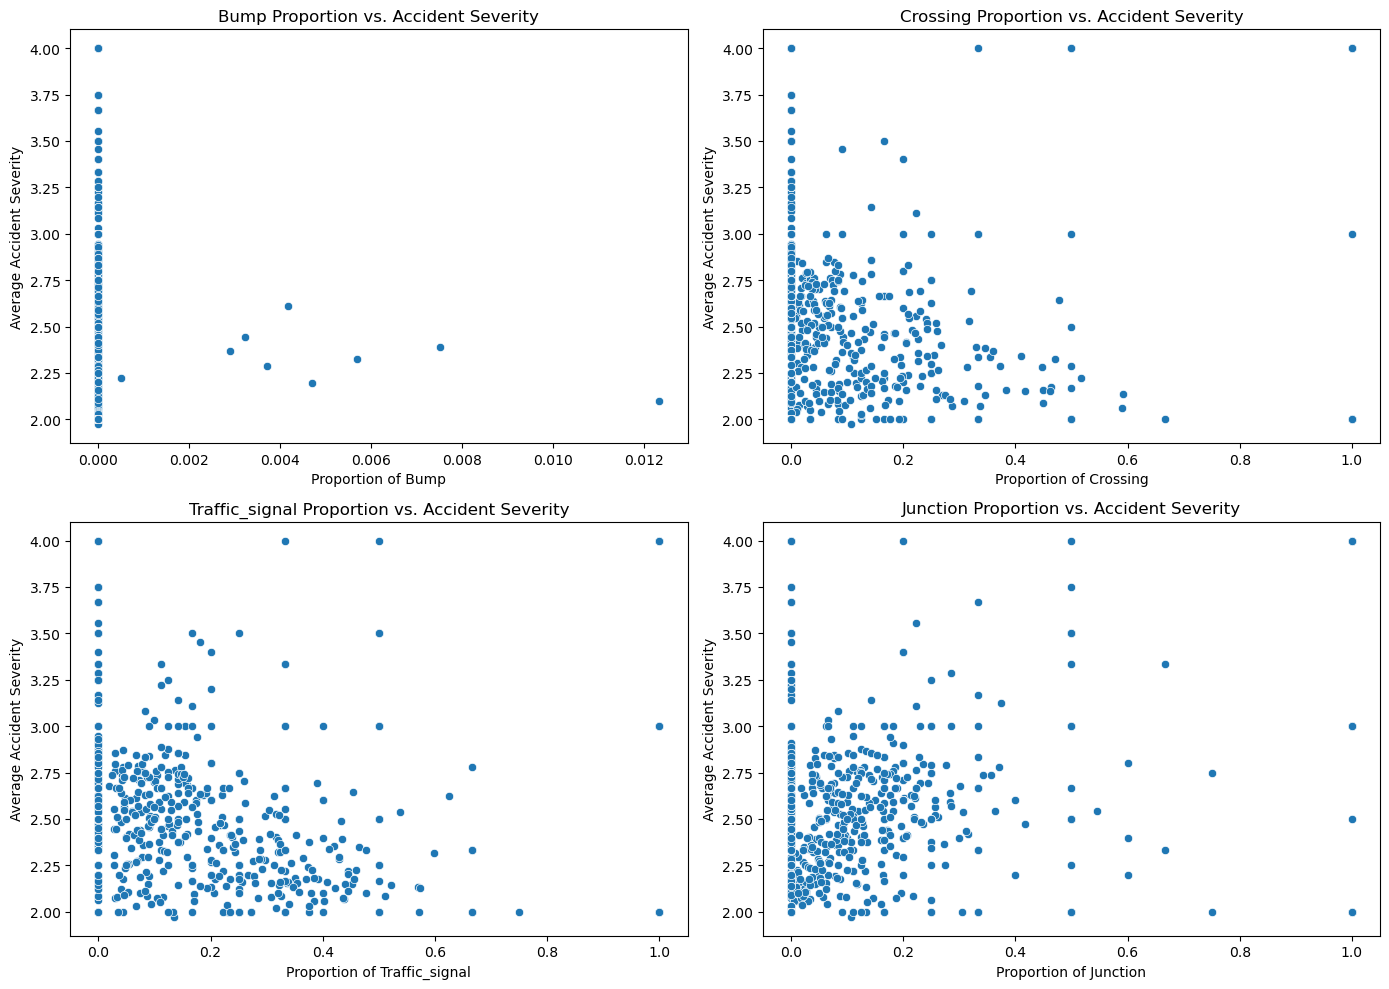

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the array of axes for easier indexing
axs = axs.flatten()

for i, condition in enumerate(road_conditions):
    sns.scatterplot(ax=axs[i], x=road_condition_severity[condition], y=road_condition_severity[severity])
    axs[i].set_title(f'{condition.capitalize()} Proportion vs. Accident Severity')
    axs[i].set_xlabel(f'Proportion of {condition.capitalize()}')
    axs[i].set_ylabel('Average Accident Severity')

plt.tight_layout()
plt.show()

Now I can draw some conclusions from the scatter plots:

1. **Low Proportion of Road Conditions at all:**
Many counties have low or zero proportions of bumps, crossings, traffic signals, and junctions, as shown by the clustering of points near zero in the scatter plots.
2. **Bumps:**
Bumps are rare but seem to reduce accident severity when present, though the data is limited.
3. **Crossings:**
Crossings vary widely across counties with no clear linear relationship to severity. High crossing proportions generally show lower severity, but outliers exist.
4. **Traffic Signals:**
Traffic signals show no strong correlation with accident severity. Some counties with many signals still experience severe accidents.
5. **Junctions:**
Junctions are more common than bumps and show varied relationships with severity, with no consistent pattern.

For now, I can say that the effectiveness of traffic control measures, such as intersections, traffic signals, and crossings, in reducing the severity of crashes is inconsistent across counties. This suggests that other factors such as roadway design, driver behavior, and socioeconomic conditions also play an important role in crash outcomes. A more comprehensive analysis accounting for these additional variables is needed to fully understand their impact on crash severity.

In my opinion, calculating the correlations between road conditions and accident severity will be a more comprehensive analysis. This approach will quantify the strength and direction of the relationship between each road condition and accident severity, providing more precise insights than simply visualizing the data with scatter plots.

In [113]:
road_conditions = ['bump', 'crossing', 'traffic_signal', 'junction']
correlations = road_condition_severity[road_conditions].corrwith(road_condition_severity[severity])

correlations

bump             -0.044322
crossing         -0.108166
traffic_signal   -0.199368
junction         -0.035796
dtype: float64

The correlation analysis between road conditions and accident severity reveals the following insights:

1. **Traffic Signal (-0.199):**
Traffic signals show the strongest negative correlation with accident severity, suggesting that areas with traffic signals tend to have less severe accidents, likely due to better traffic regulation.
2. **Crossings (-0.108)**
Crossings also have a negative correlation with accident severity, but it's weaker than traffic signals. This suggests crossings help reduce accident severity, though their impact is less significant.
3. **Bumps (-0.044):**
Bumps show a very weak negative correlation with accident severity, indicating they have minimal impact. As traffic-calming measures, they may not significantly influence accident severity.
4. **Junctions (-0.037):**
Junctions have a very weak negative correlation with accident severity, suggesting that despite their complexity, they have minimal direct impact on the severity of accidents.


So, in summary the data suggests that traffic signals are the most effective among the analyzed road conditions in reducing accident severity, followed by crossings. Bumps and junctions have minimal impact on accident severity based on the correlation analysis.

Okay, good, but i am curious what is happening with the number of accidents and the average severity that occurred under each combination of conditions.

In [114]:
road_conditions = ['bump', 'crossing', 'traffic_signal', 'junction']
severity_analysis = merged_df.groupby(road_conditions)['severity'].agg(['count', 'mean']).reset_index()

In [115]:
severity_analysis

,bump,crossing,traffic_signal,junction,count,mean
0,False,False,False,False,30728,2.463258
1,False,False,False,True,4069,2.512165
2,False,False,True,False,5189,2.181152
3,False,False,True,True,51,2.568627
4,False,True,False,False,1669,2.143200
5,False,True,False,True,29,2.448276
6,False,True,True,False,4691,2.128757
7,False,True,True,True,44,2.431818
8,True,False,False,False,9,2.222222
9,True,True,False,False,4,2.500000


**Results Analysis:**
1. `No Road Conditions` - The baseline data indicates that accidents without any road features average a severity of 2.463 and occur with a frequency of 30,754 incidents. This serves as a reference to assess how different road conditions impact both accident frequency and severity.
2. `Presence of Junction Only` - Accidents at junctions have a slightly higher severity compared to the baseline.
3. `Presence of Traffic Signal Only` - generally lead to lower accident severity, indicating that they can be beneficial in reducing the severity of accidents and improving overall traffic safety.
4. `Crossings and bumbs` - they show mixed results, with crossings linked to lower severity and bumps having relatively low accident counts, implying that their effects on accident outcomes may be less significant.

`In summary`, having specific road features can be both beneficial and problematic. Features like traffic signals can enhance safety by reducing severity, while junctions may pose increased risks. The effectiveness of road features largely depends on their design and implementation. Properly designed and well-maintained road features are generally beneficial, but those that are poorly managed or not well-integrated may contribute to higher accident severity. 

10. How do different racial and ethnic groups correlate with traffic accident rates?
11. Do counties with higher percentages of residents working from home experience fewer traffic accidents?
14. Explore and visualize patterns in the data that reveal how different counties or regions may be more susceptible to traffic accidents due to their demographic makeup or environmental conditions.
15. Provide insights that could help policymakers, urban planners, and public safety officials design targeted interventions to reduce traffic accidents. For example, identifying high-risk areas or populations could lead to more effective road safety campaigns, infrastructure improvements, or traffic regulations.
16. Is there a correlation between unemployment or income levels and accident rates?
17. How does transportation mode (drive, carpool, transit, walk) correlate with accident rates in different counties?